# Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, PolynomialFeatures

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, log_loss

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import optuna
import warnings 
warnings.filterwarnings('ignore')

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
# Setting Dataframe environment
pd.set_option('display.max_rows',25)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format',lambda x: '%.3f'%x)

## Data Preparation

In [17]:
df = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
df.sample(3)

id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
125650  125650   55         165          60     76.000           0.600   
77651    77651   40         175          80     91.000           1.200   
114421  114421   50         155          55     64.000           0.700   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
125650            0.800              1               1       118          72   
77651             1.200              1               1       124          80   
114421            0.200              1               1        93          71   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
125650                  104          248            72   91  145      15.000   
77651                   108          224           399   41  112      16.700   
114421                   80          215            87   50  146      13.400   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  smoking  
125650              1             0.800   25   16   22              0        0  
77651               1             1.000   27   39   65              0        1  
114421              1             0.800   22   16   17              1        0

In [18]:
test.sample(3)

id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
29932  189188   40         180          70     82.000           0.800   
72391  231647   40         150          55     73.000           0.400   
38985  198241   40         150          50     81.000           0.700   

       eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
29932            0.800              1               1       126          75   
72391            0.500              1               1       115          72   
38985            0.700              1               1       131          85   

       fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
29932                  116          191           164   48  110      14.700   
72391                   83          128            45   45   74      12.600   
38985                   82          174            29   92   74      12.600   

       Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  
29932              1             0.900   15   13   18              0  
72391              1             0.900   18    7   15              0  
38985              1             0.600   17   14   14              0

In [19]:
# shapes
print('shape of train is :',df.shape)
print('shape of test is :',test.shape)

shape of train is : (159256, 24)
shape of test is : (106171, 23)


In [20]:
# Removing ID column to reduce extra computation as it provides no information
def remove_id(df):
    return df.drop('id',axis=1,inplace=True)

test_id = test['id']
remove_id(df)
remove_id(test)

# Geneerate statistics for each column
df.describe()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
count 159256.000  159256.000  159256.000 159256.000      159256.000   
mean      44.307     165.267      67.144     83.002           1.006   
std       11.842       8.819      12.586      8.958           0.402   
min       20.000     135.000      30.000     51.000           0.100   
25%       40.000     160.000      60.000     77.000           0.800   
50%       40.000     165.000      65.000     83.000           1.000   
75%       55.000     170.000      75.000     89.000           1.200   
max       85.000     190.000     130.000    127.000           9.900   

       eyesight(right)  hearing(left)  hearing(right)   systolic  relaxation  \
count       159256.000     159256.000      159256.000 159256.000  159256.000   
mean             1.001          1.024           1.023    122.504      76.874   
std              0.392          0.153           0.151     12.729       8.995   
min              0.100          1.000           1.000     77.000      44.000   
25%              0.800          1.000           1.000    114.000      70.000   
50%              1.000          1.000           1.000    121.000      78.000   
75%              1.200          1.000           1.000    130.000      82.000   
max              9.900          2.000           2.000    213.000     133.000   

       fasting blood sugar  Cholesterol  triglyceride        HDL        LDL  \
count           159256.000   159256.000    159256.000 159256.000 159256.000   
mean                98.353      195.796       127.616     55.853    114.608   
std                 15.330       28.397        66.189     13.964     28.159   
min                 46.000       77.000         8.000      9.000      1.000   
25%                 90.000      175.000        77.000     45.000     95.000   
50%                 96.000      196.000       115.000     54.000    114.000   
75%                103.000      217.000       165.000     64.000    133.000   
max                375.000      393.000       766.000    136.000   1860.000   

       hemoglobin  Urine protein  serum creatinine        AST        ALT  \
count  159256.000     159256.000        159256.000 159256.000 159256.000   
mean       14.797          1.074             0.893     25.517     26.550   
std         1.431          0.348             0.179      9.465     17.753   
min         4.900          1.000             0.100      6.000      1.000   
25%        13.800          1.000             0.800     20.000     16.000   
50%        15.000          1.000             0.900     24.000     22.000   
75%        15.800          1.000             1.000     29.000     32.000   
max        21.000          6.000             9.900    778.000   2914.000   

             Gtp  dental caries    smoking  
count 159256.000     159256.000 159256.000  
mean      36.216          0.198      0.437  
std       31.205          0.398      0.496  
min        2.000          0.000      0.000  
25%       18.000          0.000      0.000  
50%       27.000          0.000      0.000  
75%       44.000          0.000      1.000  
max      999.000          1.000      1.000

In [21]:
# unique values in all columns
for i in df.columns:
    print(f'{i:19}','-->',df[i].nunique())

age                 --> 18
height(cm)          --> 14
weight(kg)          --> 28
waist(cm)           --> 531
eyesight(left)      --> 20
eyesight(right)     --> 17
hearing(left)       --> 2
hearing(right)      --> 2
systolic            --> 112
relaxation          --> 75
fasting blood sugar --> 229
Cholesterol         --> 227
triglyceride        --> 392
HDL                 --> 108
LDL                 --> 222
hemoglobin          --> 134
Urine protein       --> 6
serum creatinine    --> 28
AST                 --> 140
ALT                 --> 188
Gtp                 --> 362
dental caries       --> 2
smoking             --> 2


### Data Visualization

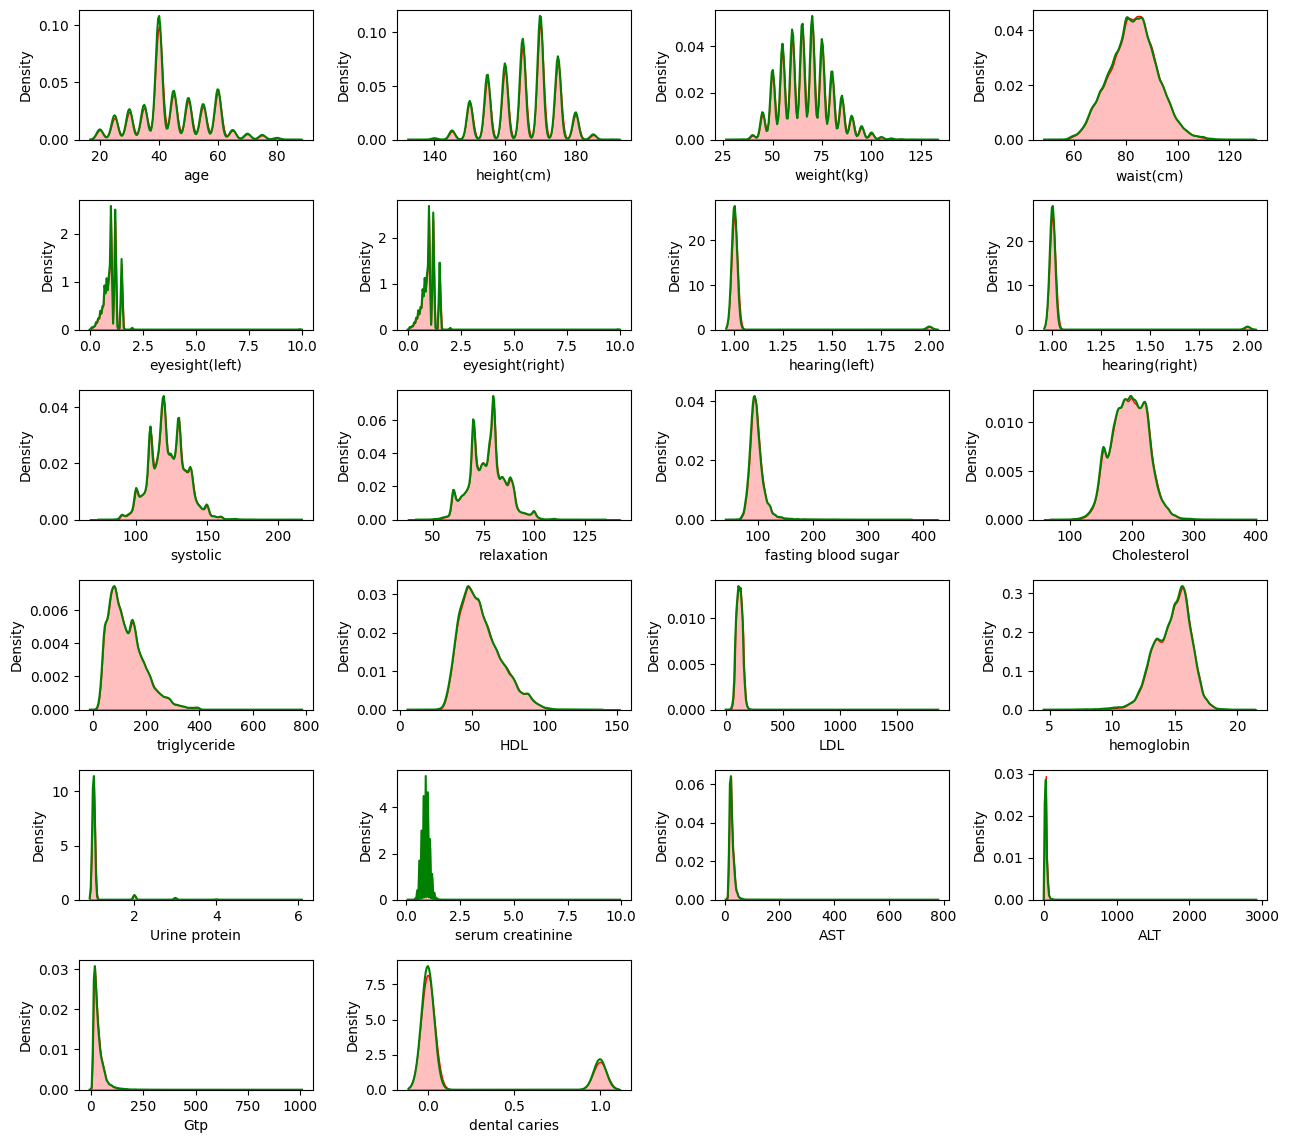

In [22]:
# checking data distribution and spotting if there is any leakage
fig =plt.figure(figsize=(13,13))

j=0
for i in test.columns:
    fig.add_subplot(7,4,j+1)
    sns.kdeplot(df,x=i,color='green')
    sns.kdeplot(test,x=i,color='red',fill=True)
    j += 1
plt.tight_layout()
plt.show()

# serum creatinine seems to be different in density amounts 
# in other columns no major data leakage
# many columnns are right skewed

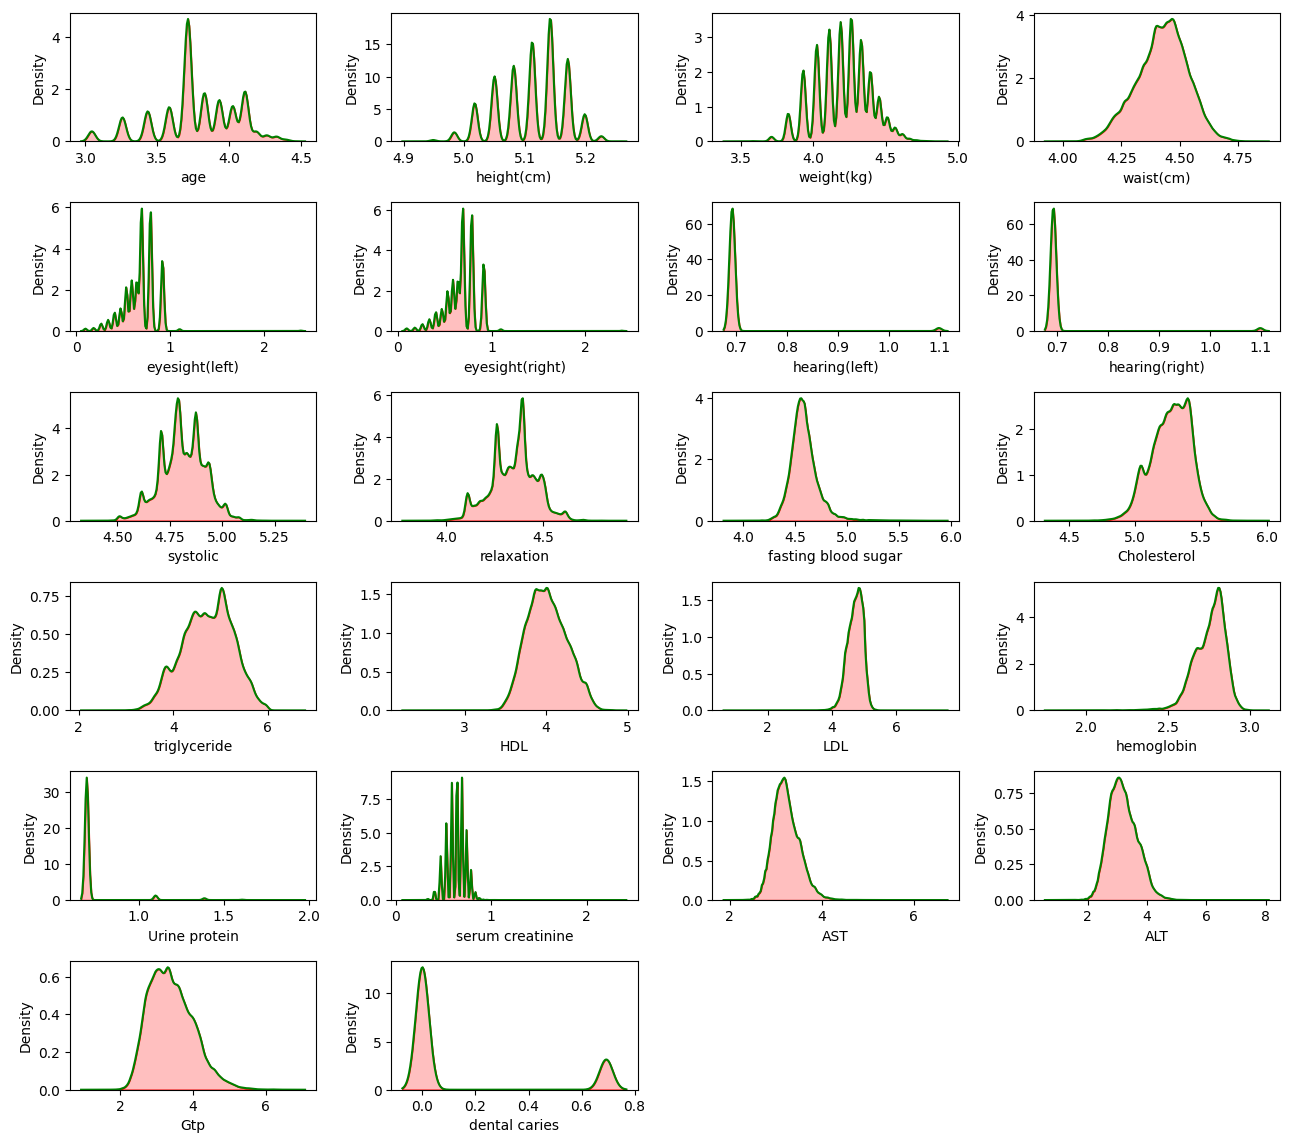

In [23]:
# adding 1 and transforming all columns into there log values  (as there are some zeroes)
# to see if we can reduce skewness

fig =plt.figure(figsize=(13,13))

for i in range(len(test.columns)):
    fig.add_subplot(7,4,i+1)
    sns.kdeplot(x=np.log1p(df[f'{test.columns[i]}']),color='green')
    sns.kdeplot(x=np.log1p(df[f'{test.columns[i]}']),color='red',fill=True)
plt.tight_layout()
plt.show()

# log is good for eyesight(left), eyesight(right), systolic, relaxation, fasting blood sugar, 
# triglyceride, HDL, LDL, hemoglobin, serum creatinine,
# AST, ALT, Gtp

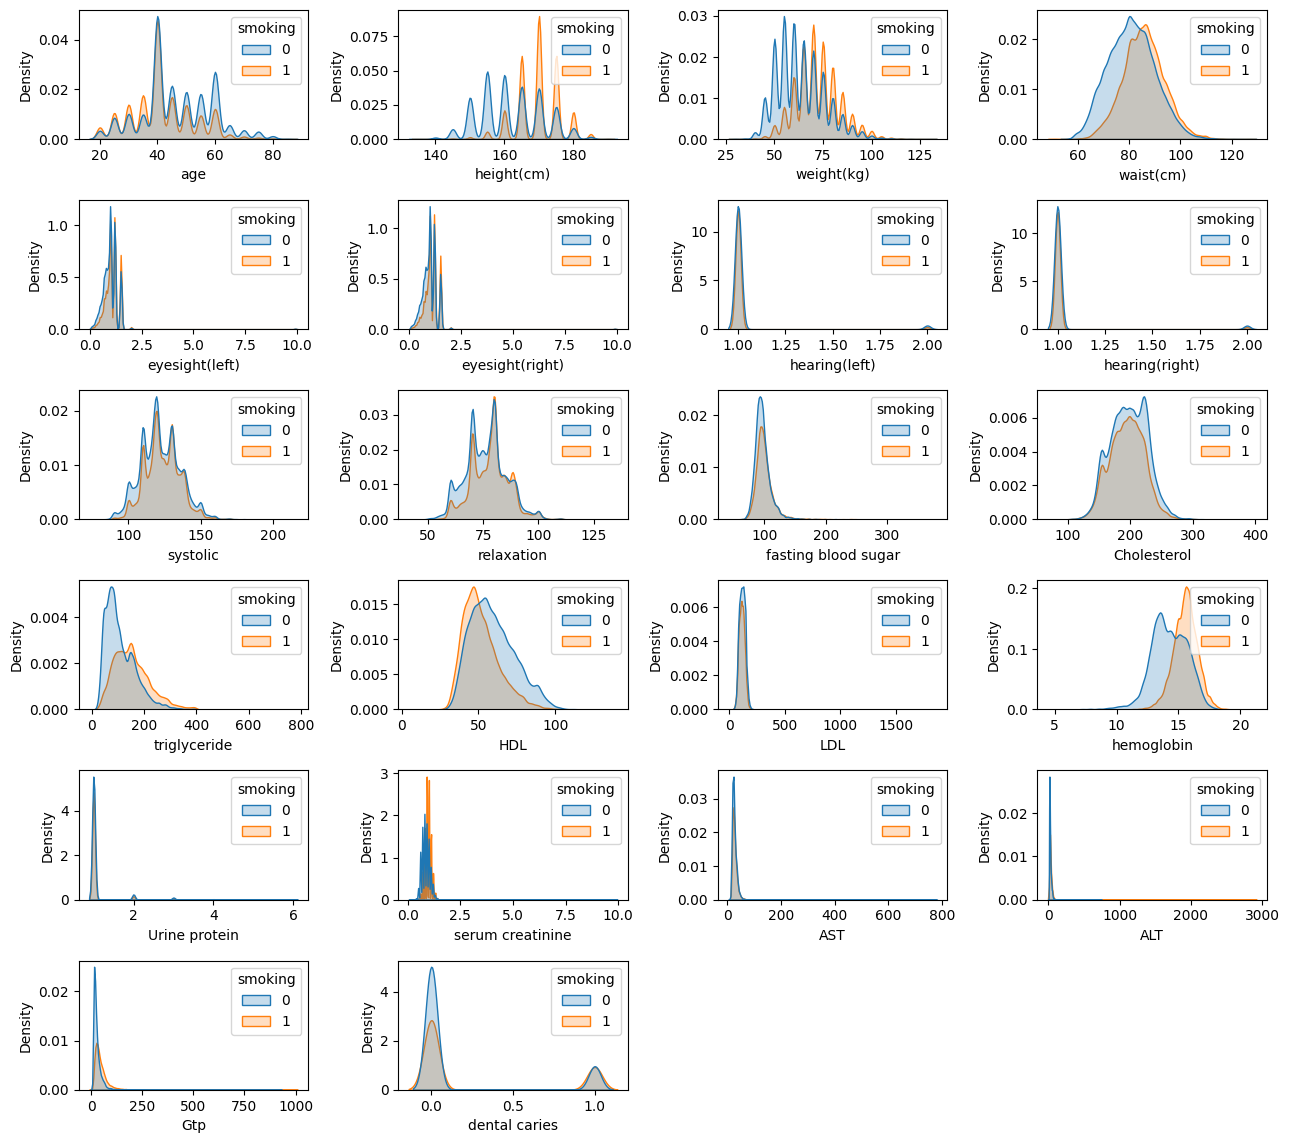

In [24]:
# Distributions of all columns on the basis of smoking status

fig =plt.figure(figsize=(13,13))
j=0
for i in test.columns:
    fig.add_subplot(7,4,j+1)
    sns.kdeplot(df,x=i,hue='smoking',fill=True)
    j += 1
plt.tight_layout()
plt.show()

# we can see some significant observaion in distributions.

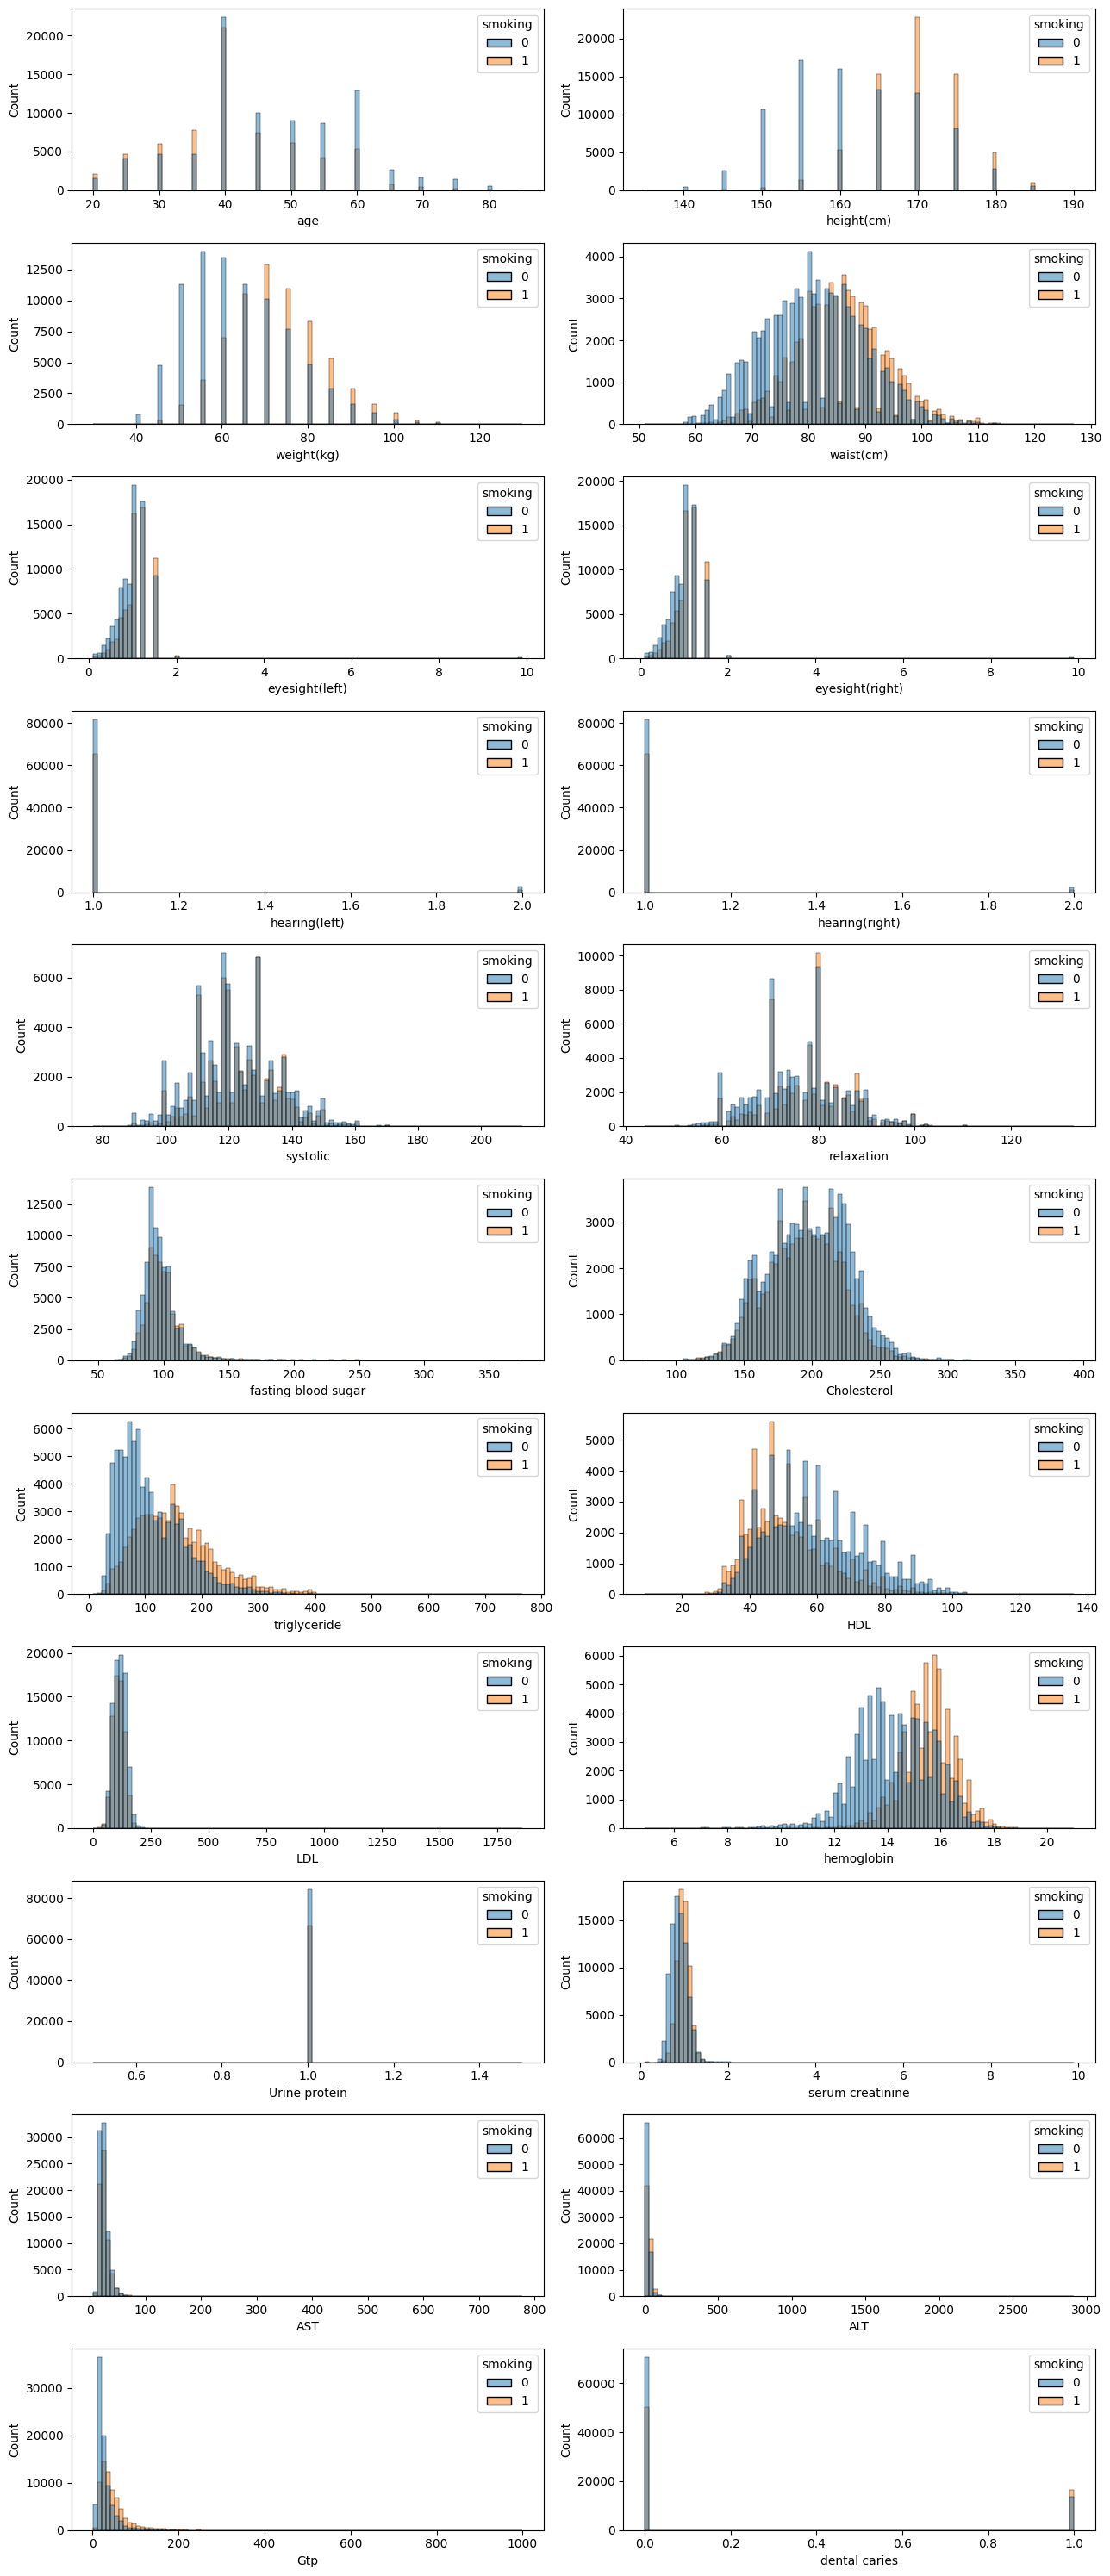

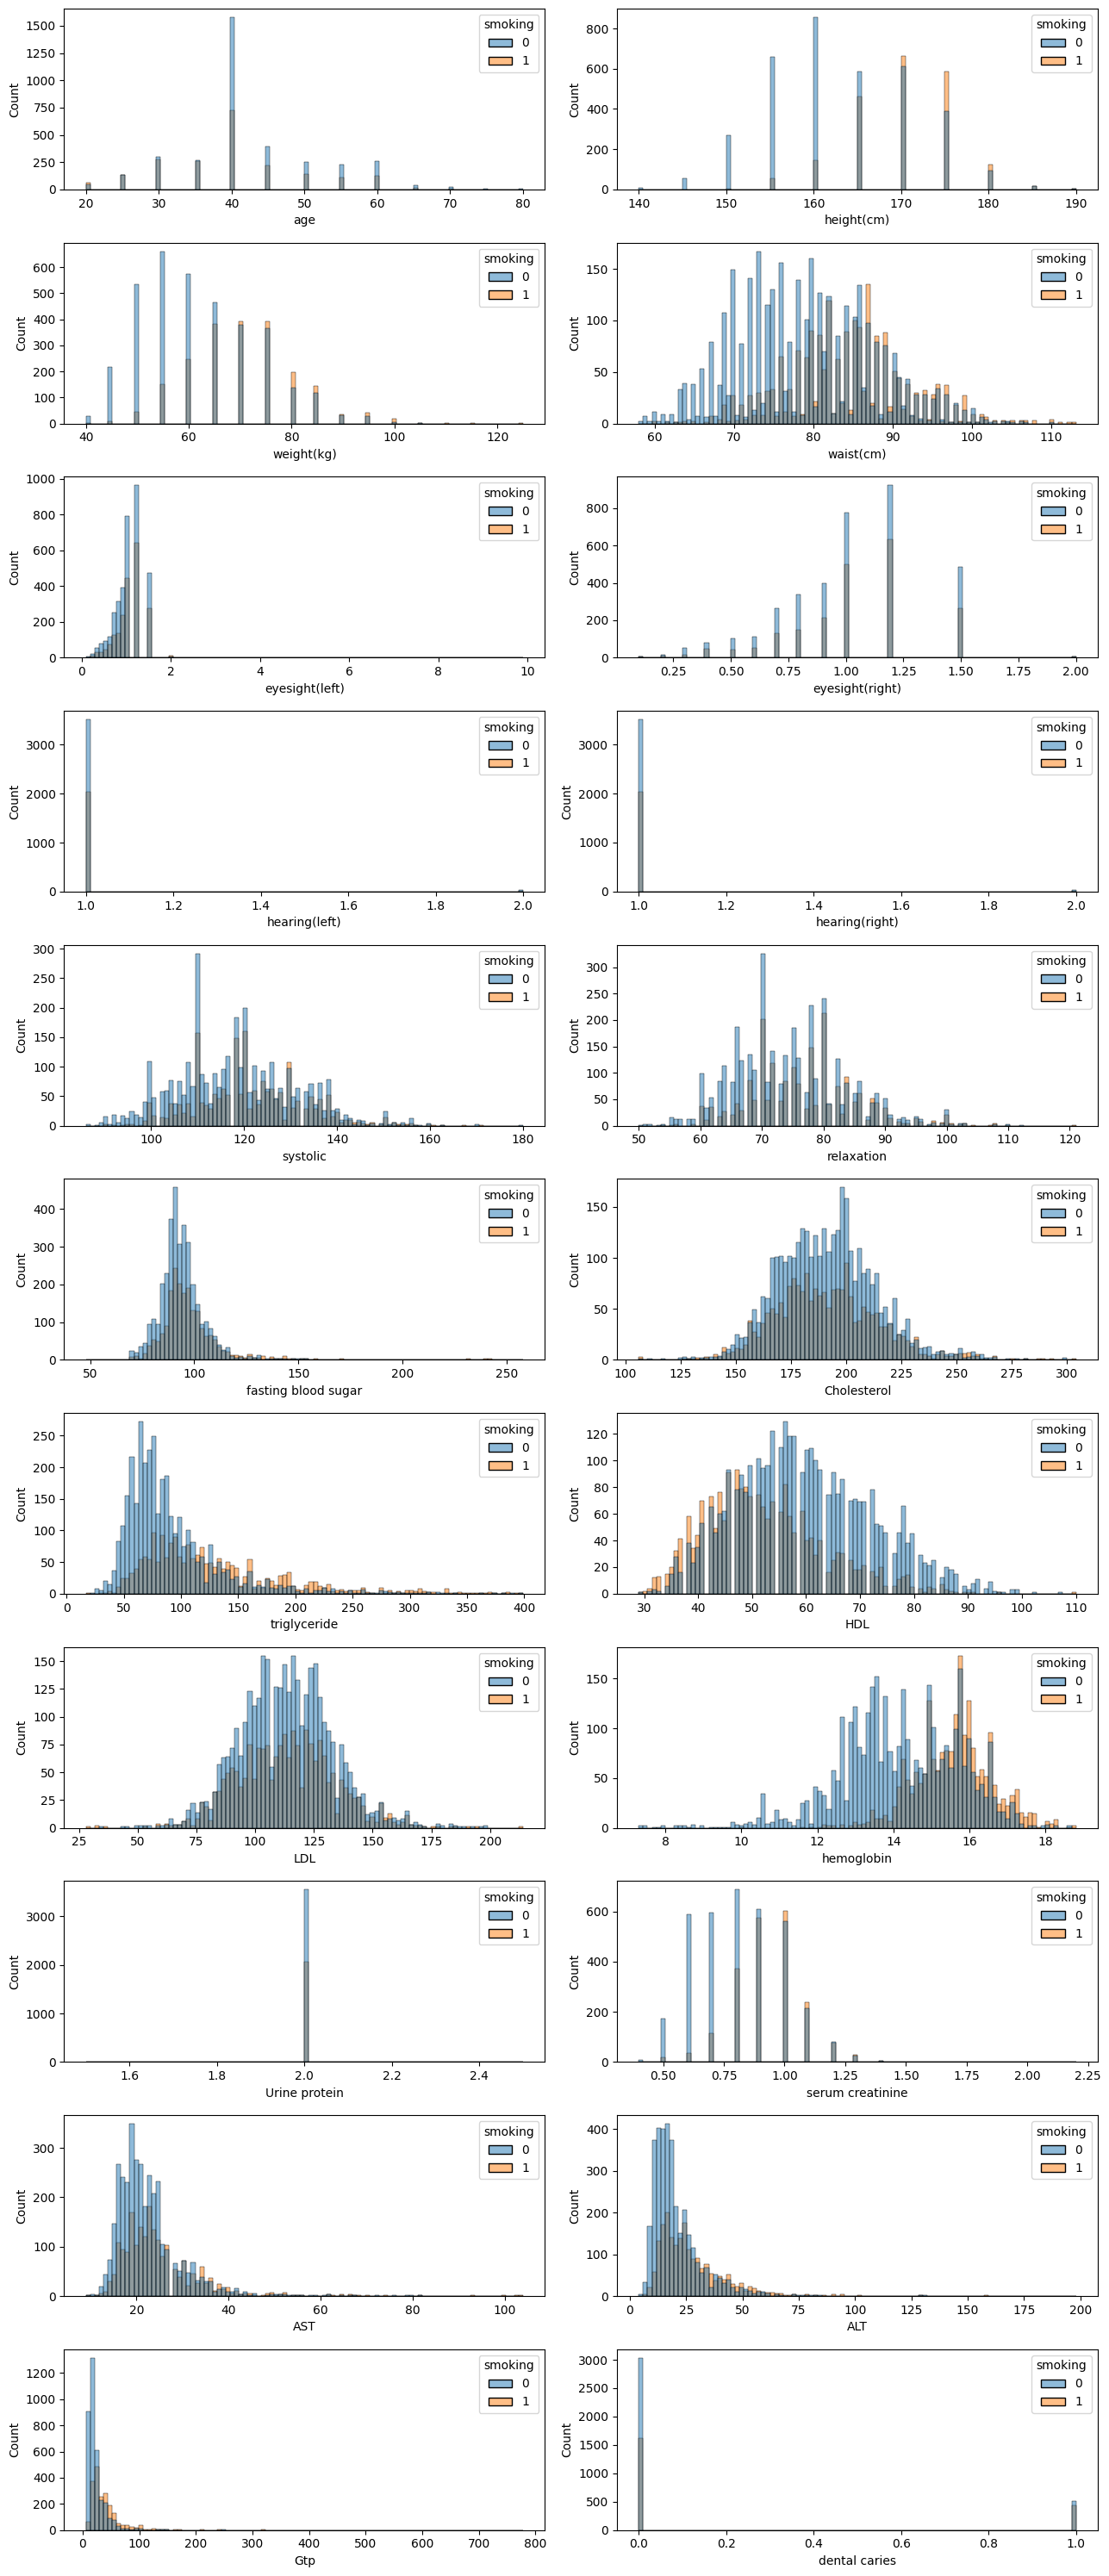

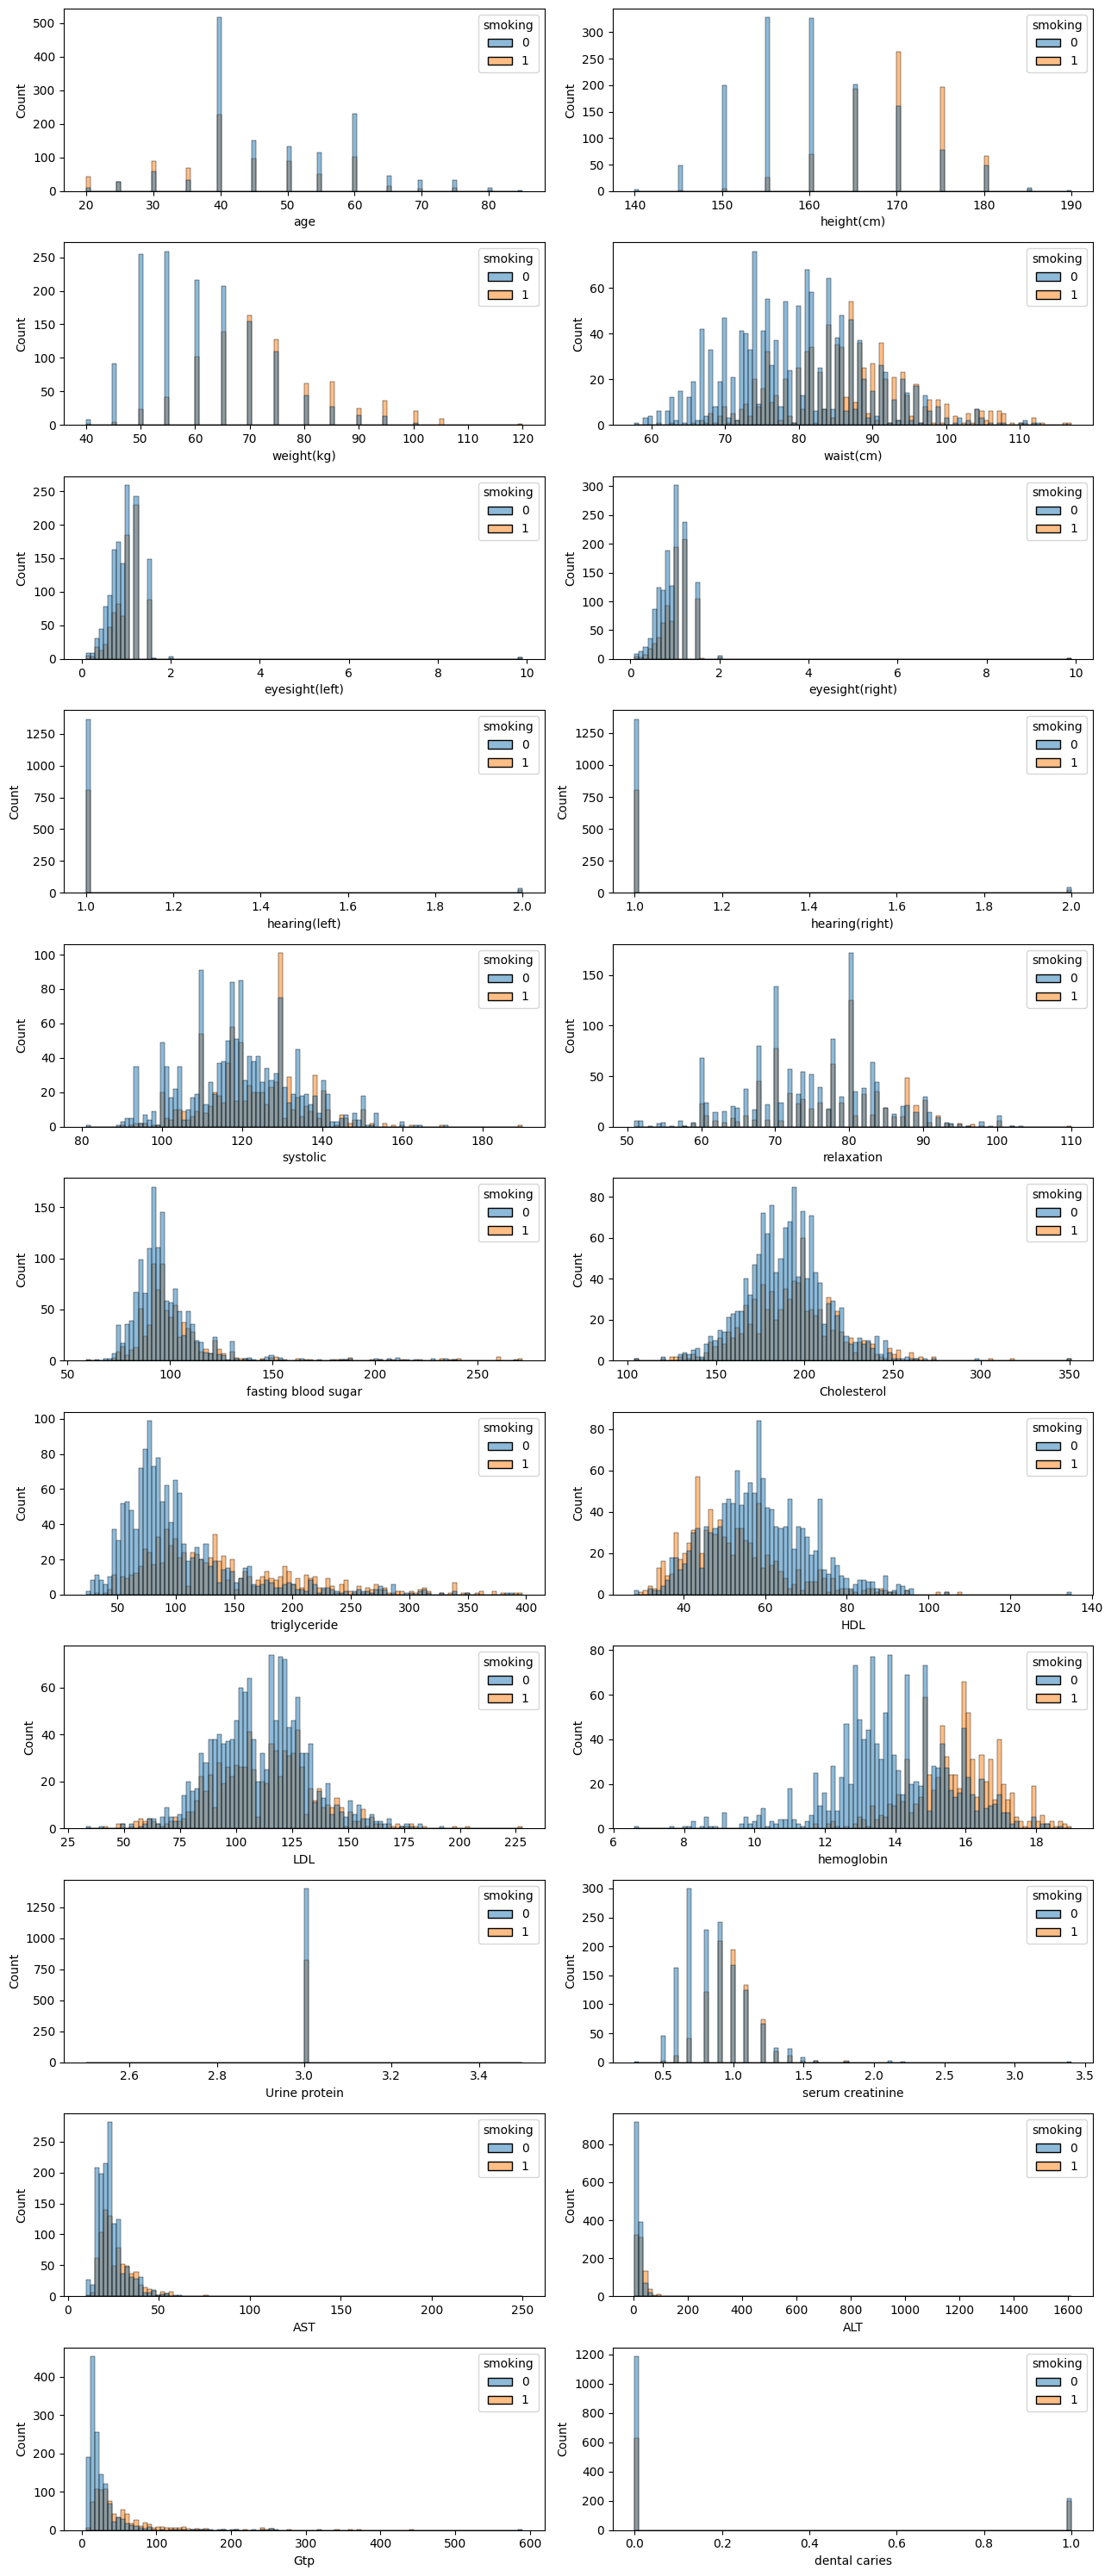

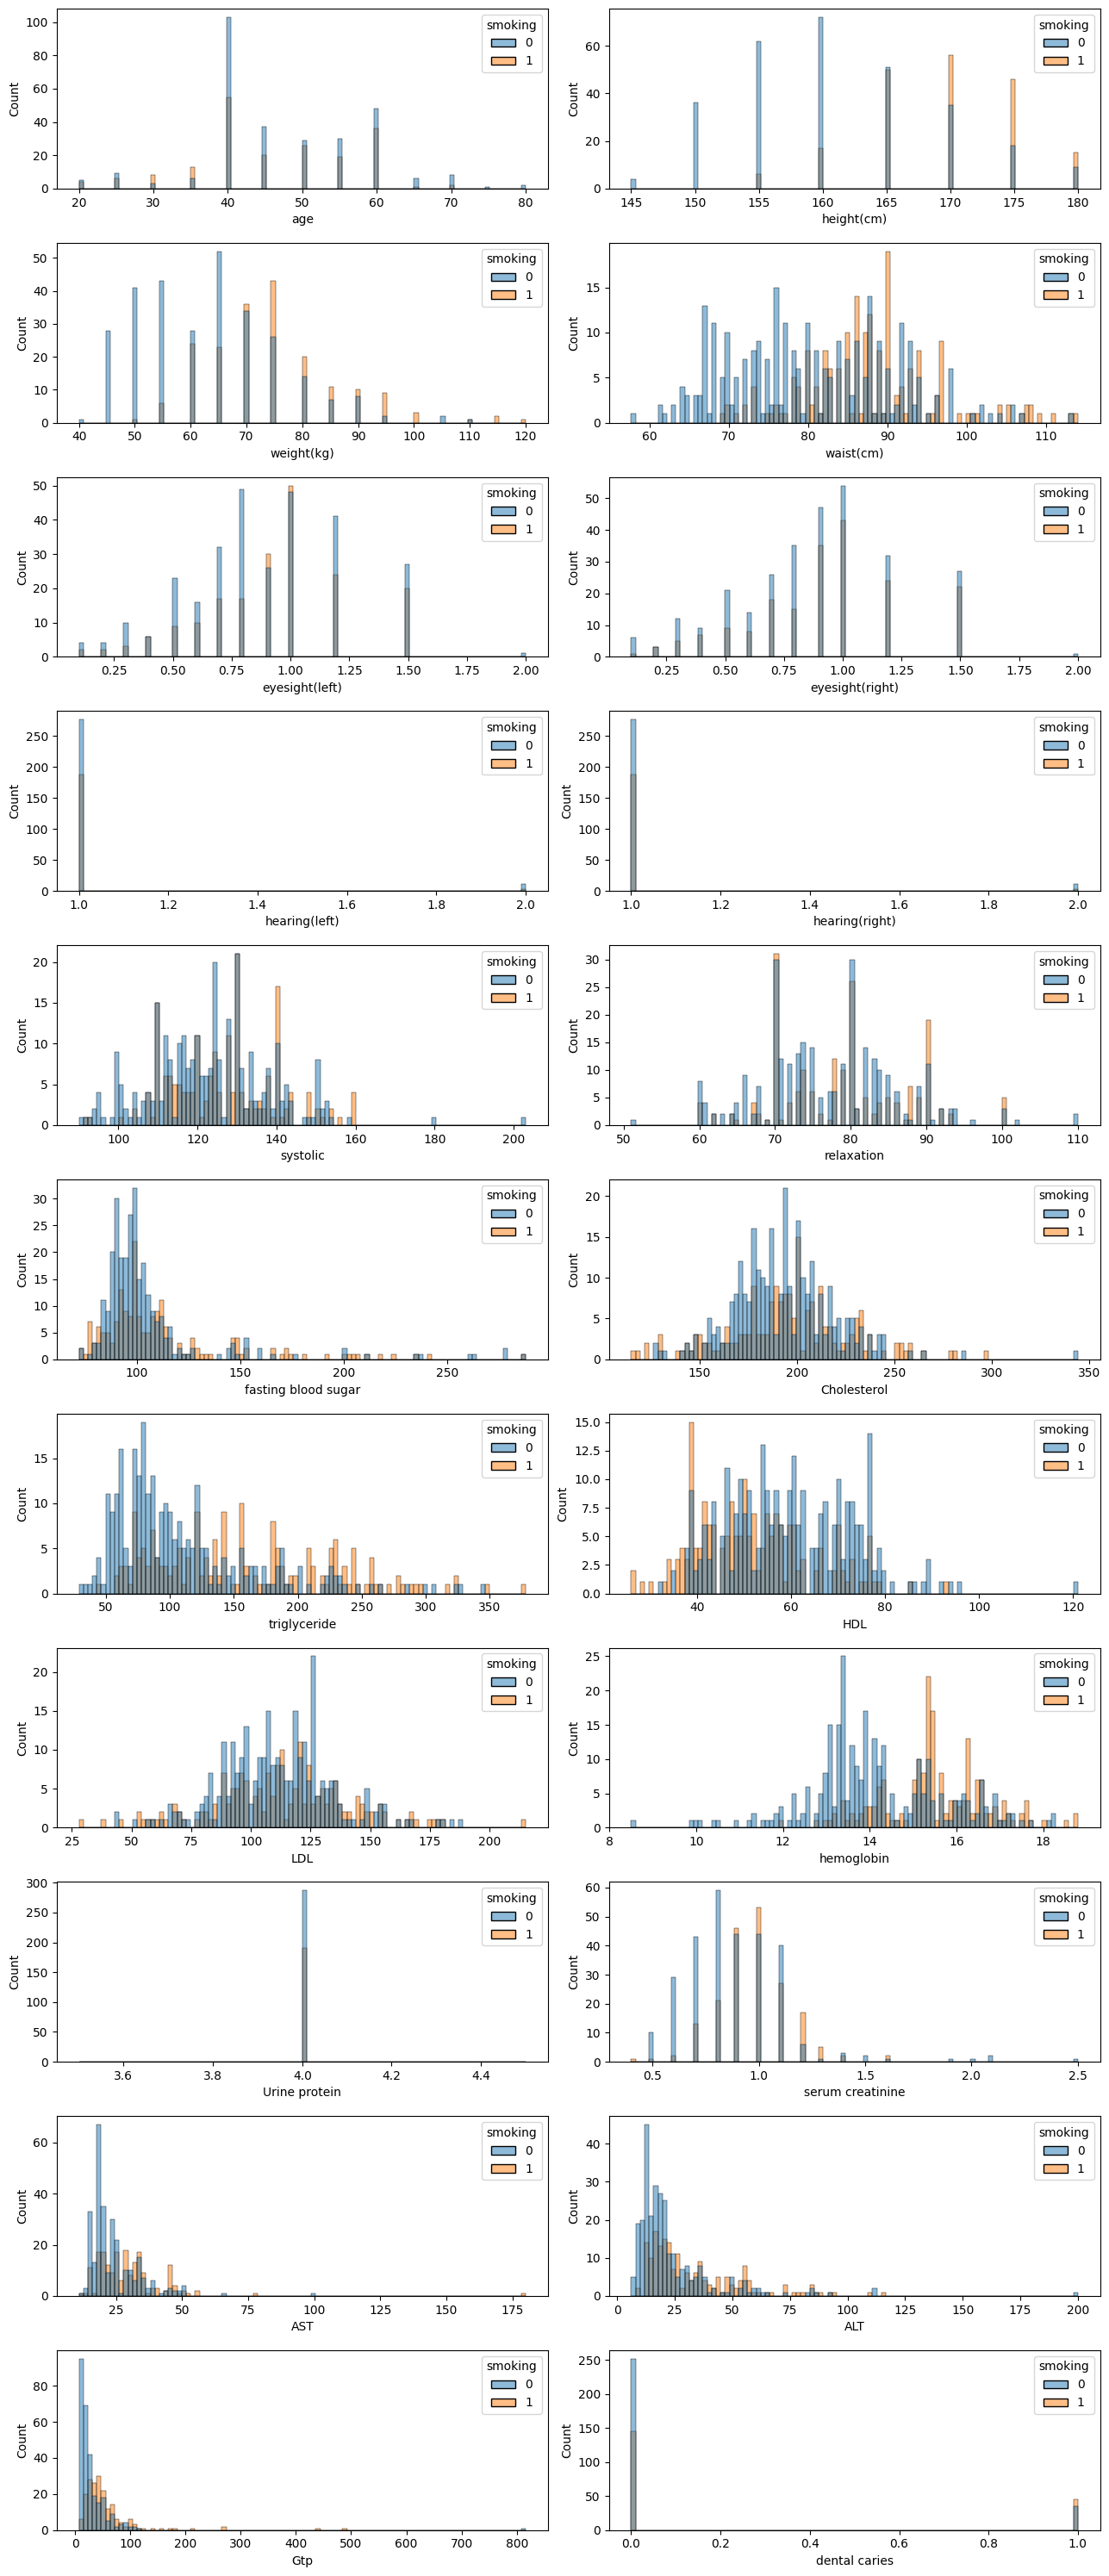

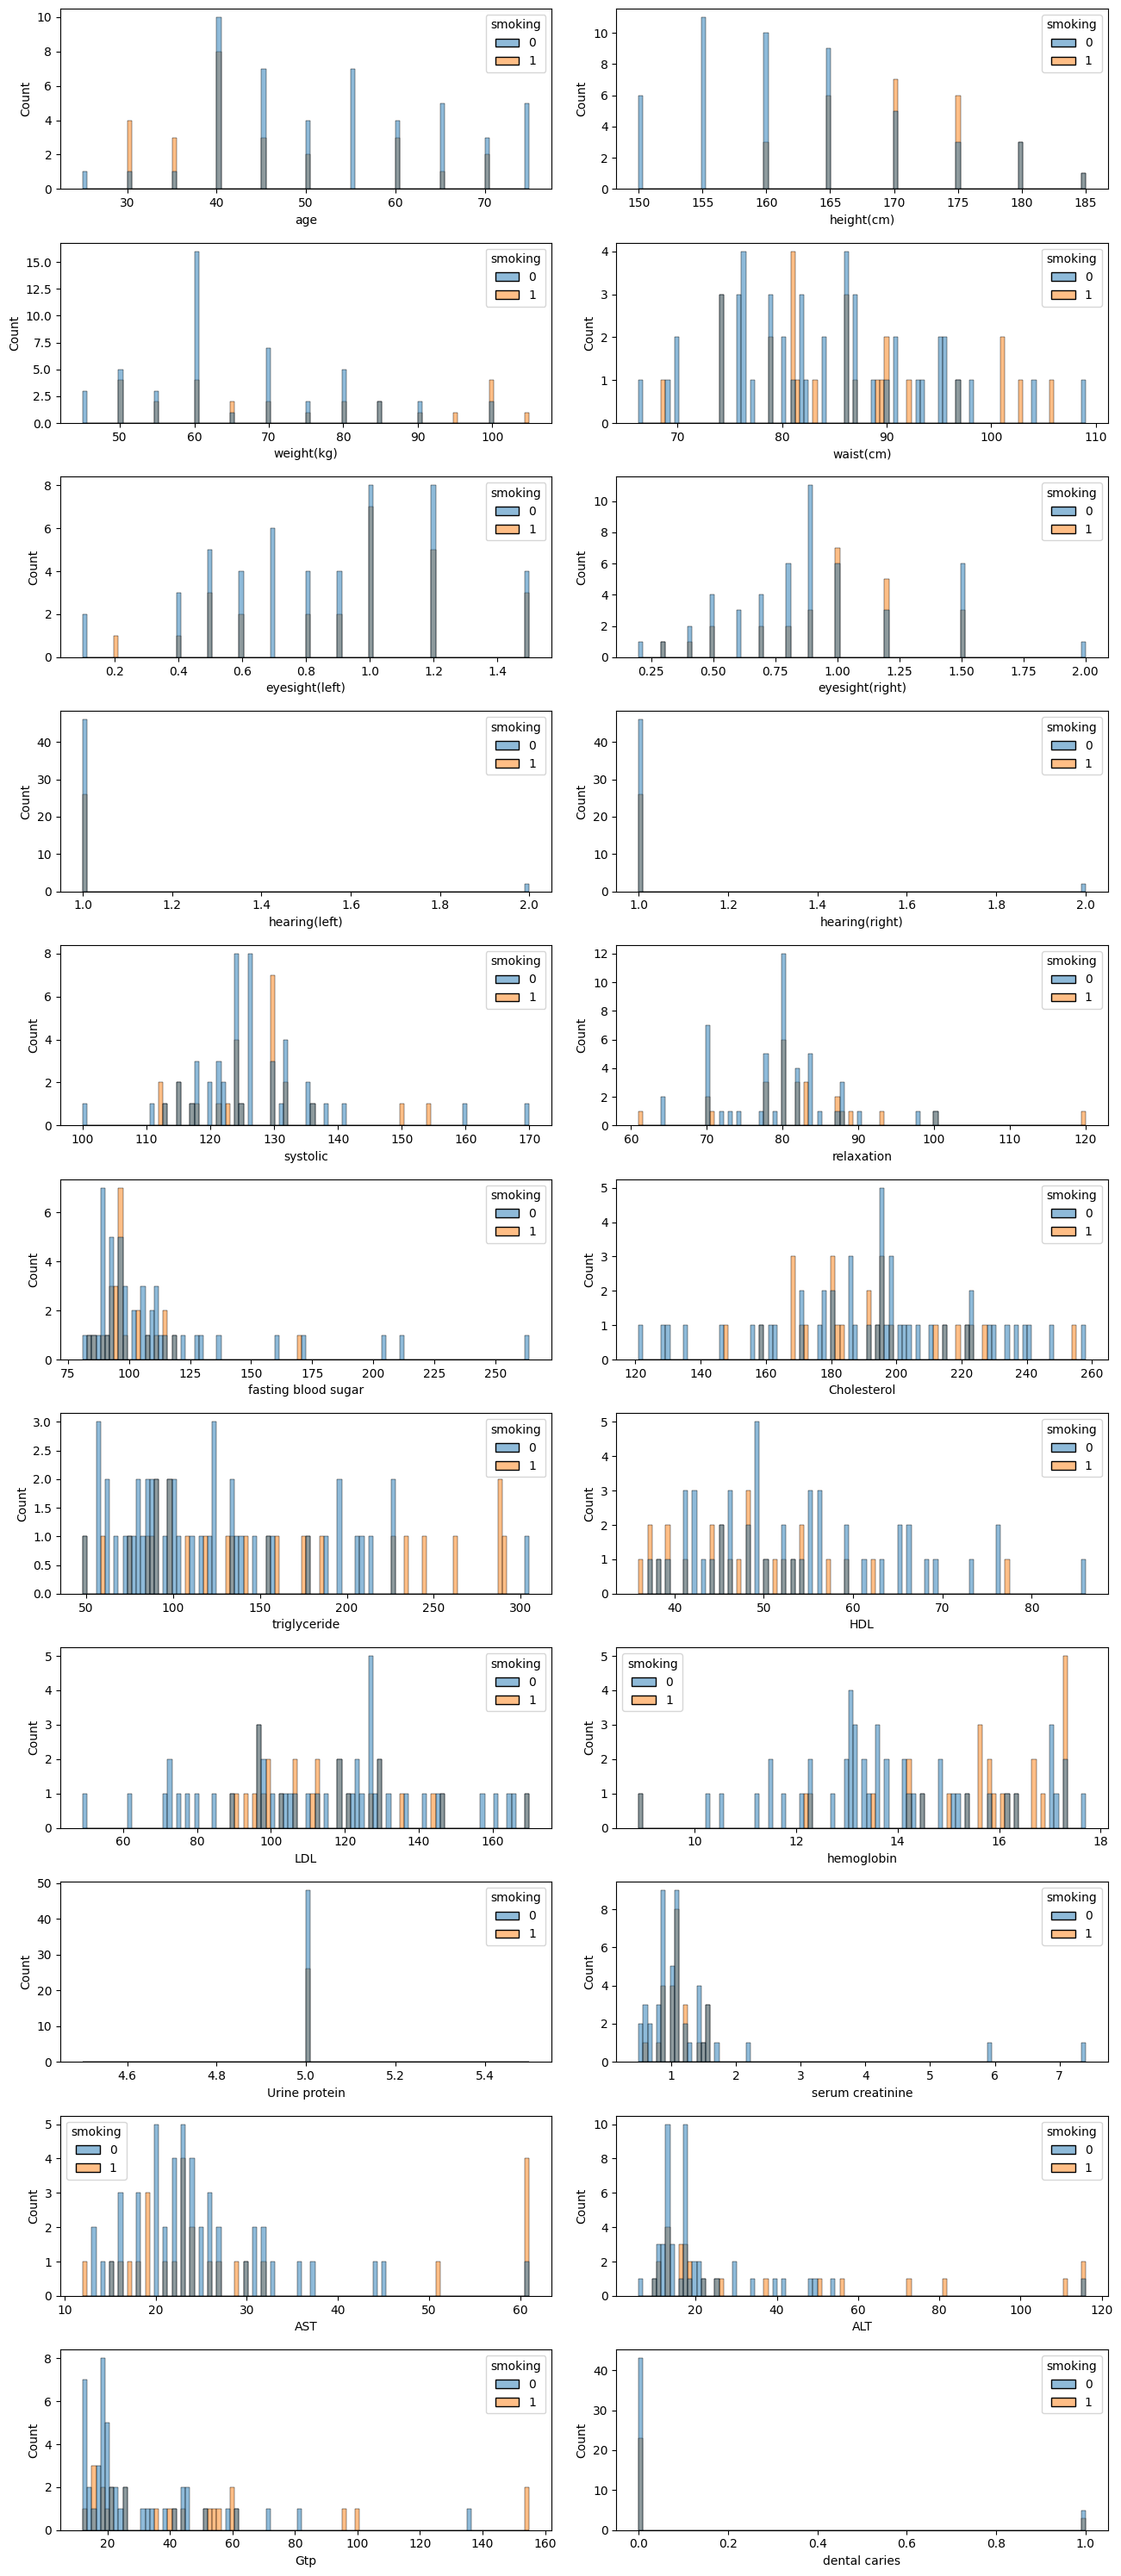

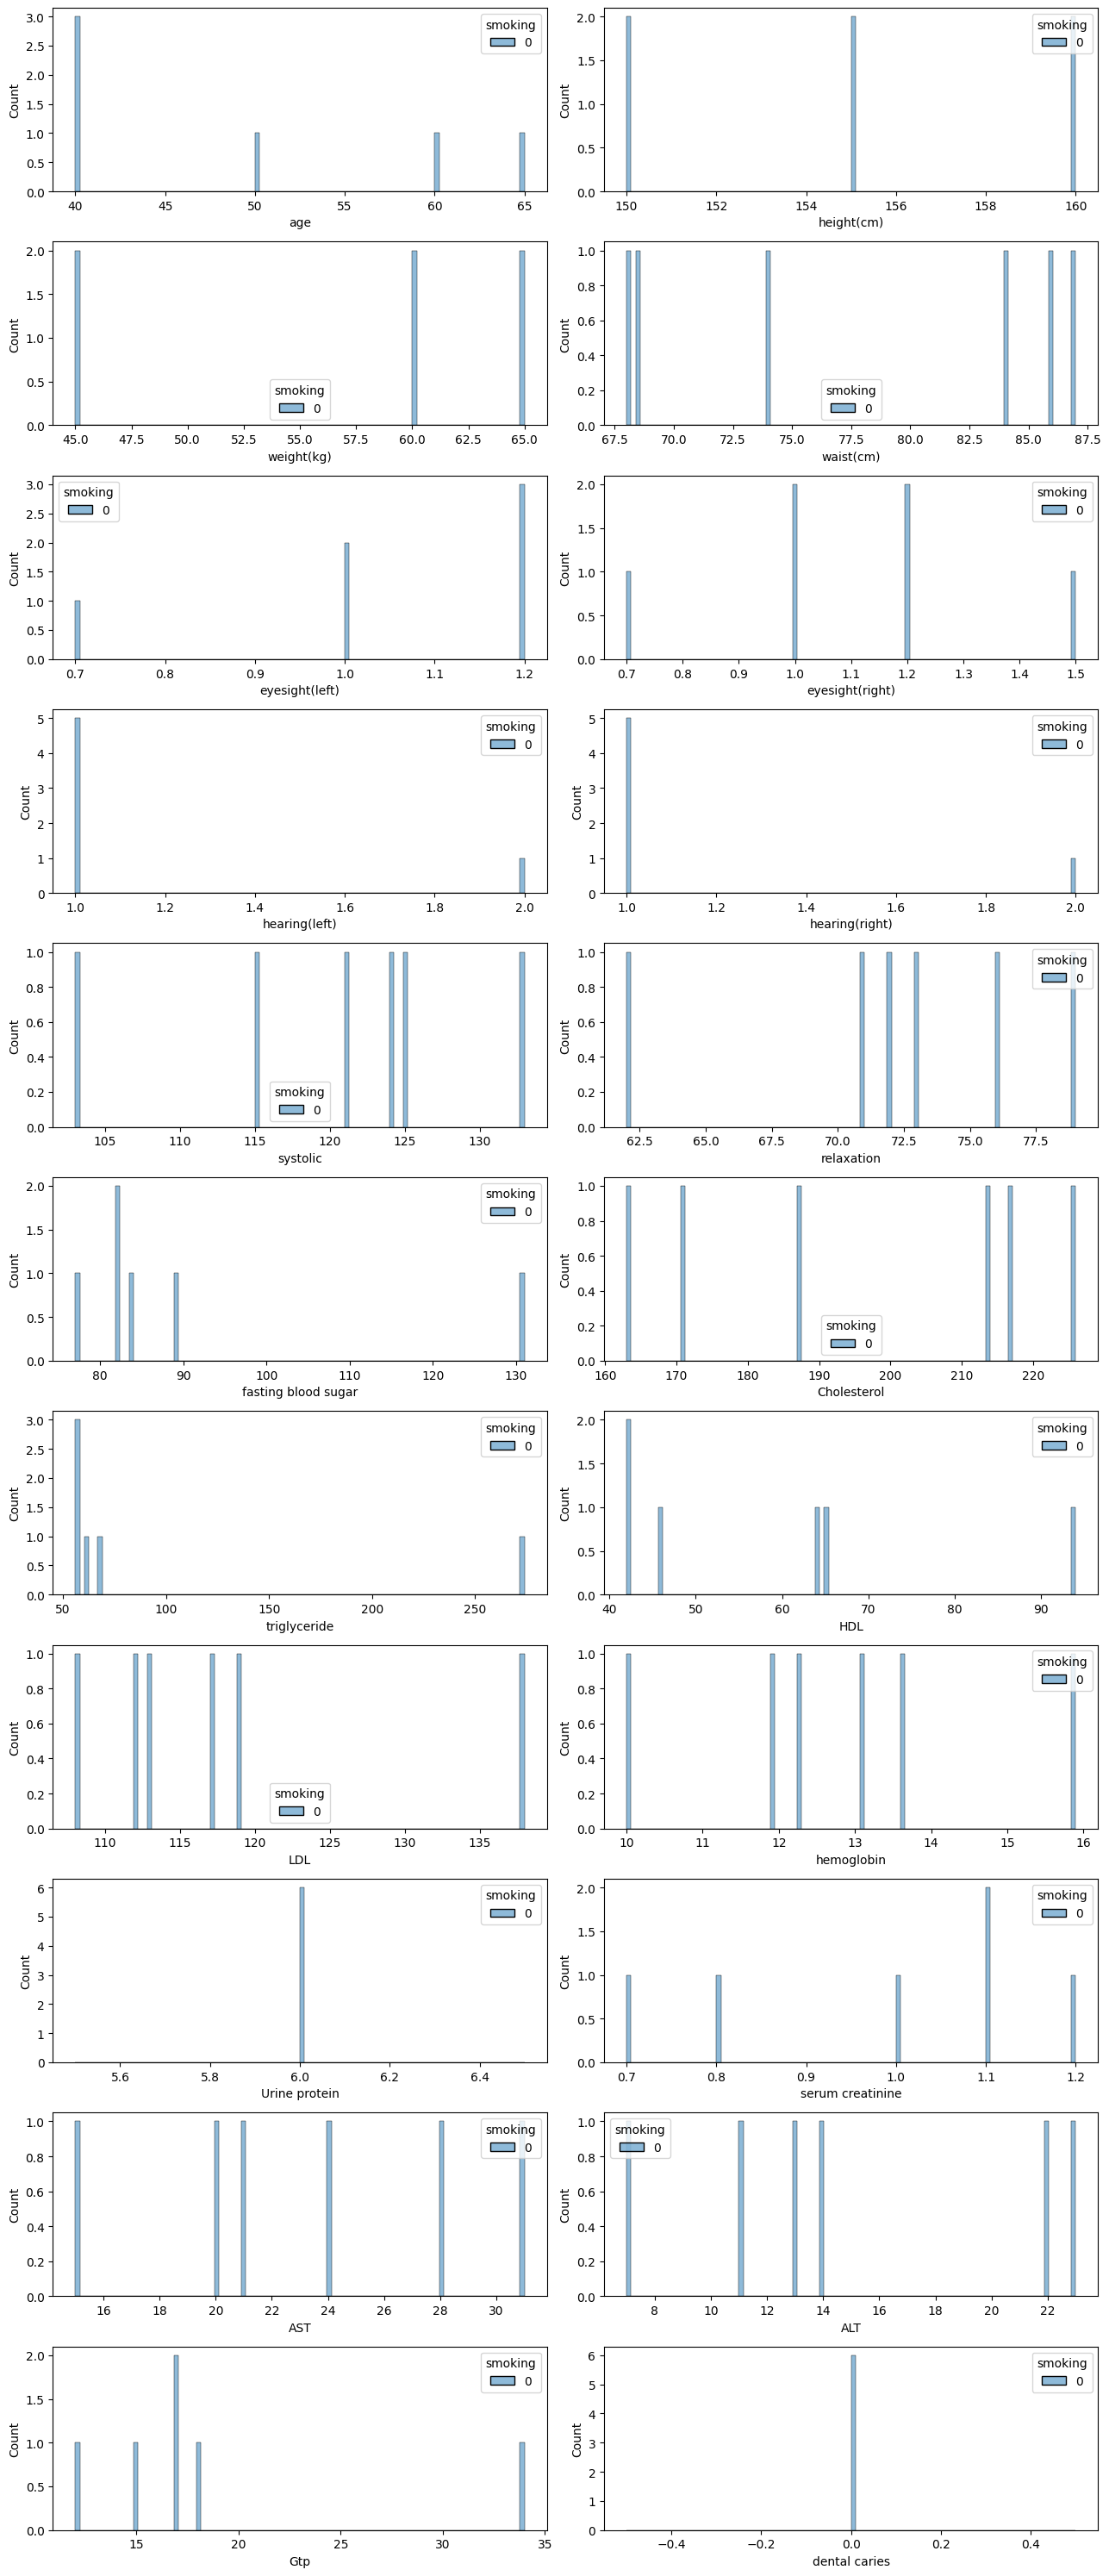

In [25]:
for i in range(1,7):
    protein_filter = (df['Urine protein']==i)
    fig =plt.figure(figsize=(13,30))

    j=0
    for i in test.columns:
        fig.add_subplot(11,2,j+1)
        sns.histplot(df[protein_filter],x=i,hue='smoking',fill=True,bins=100)
        j += 1
    plt.tight_layout()
    plt.show()

# this plot plots histogram of every feature to get noticable variation but
# But no significant observation appeared 

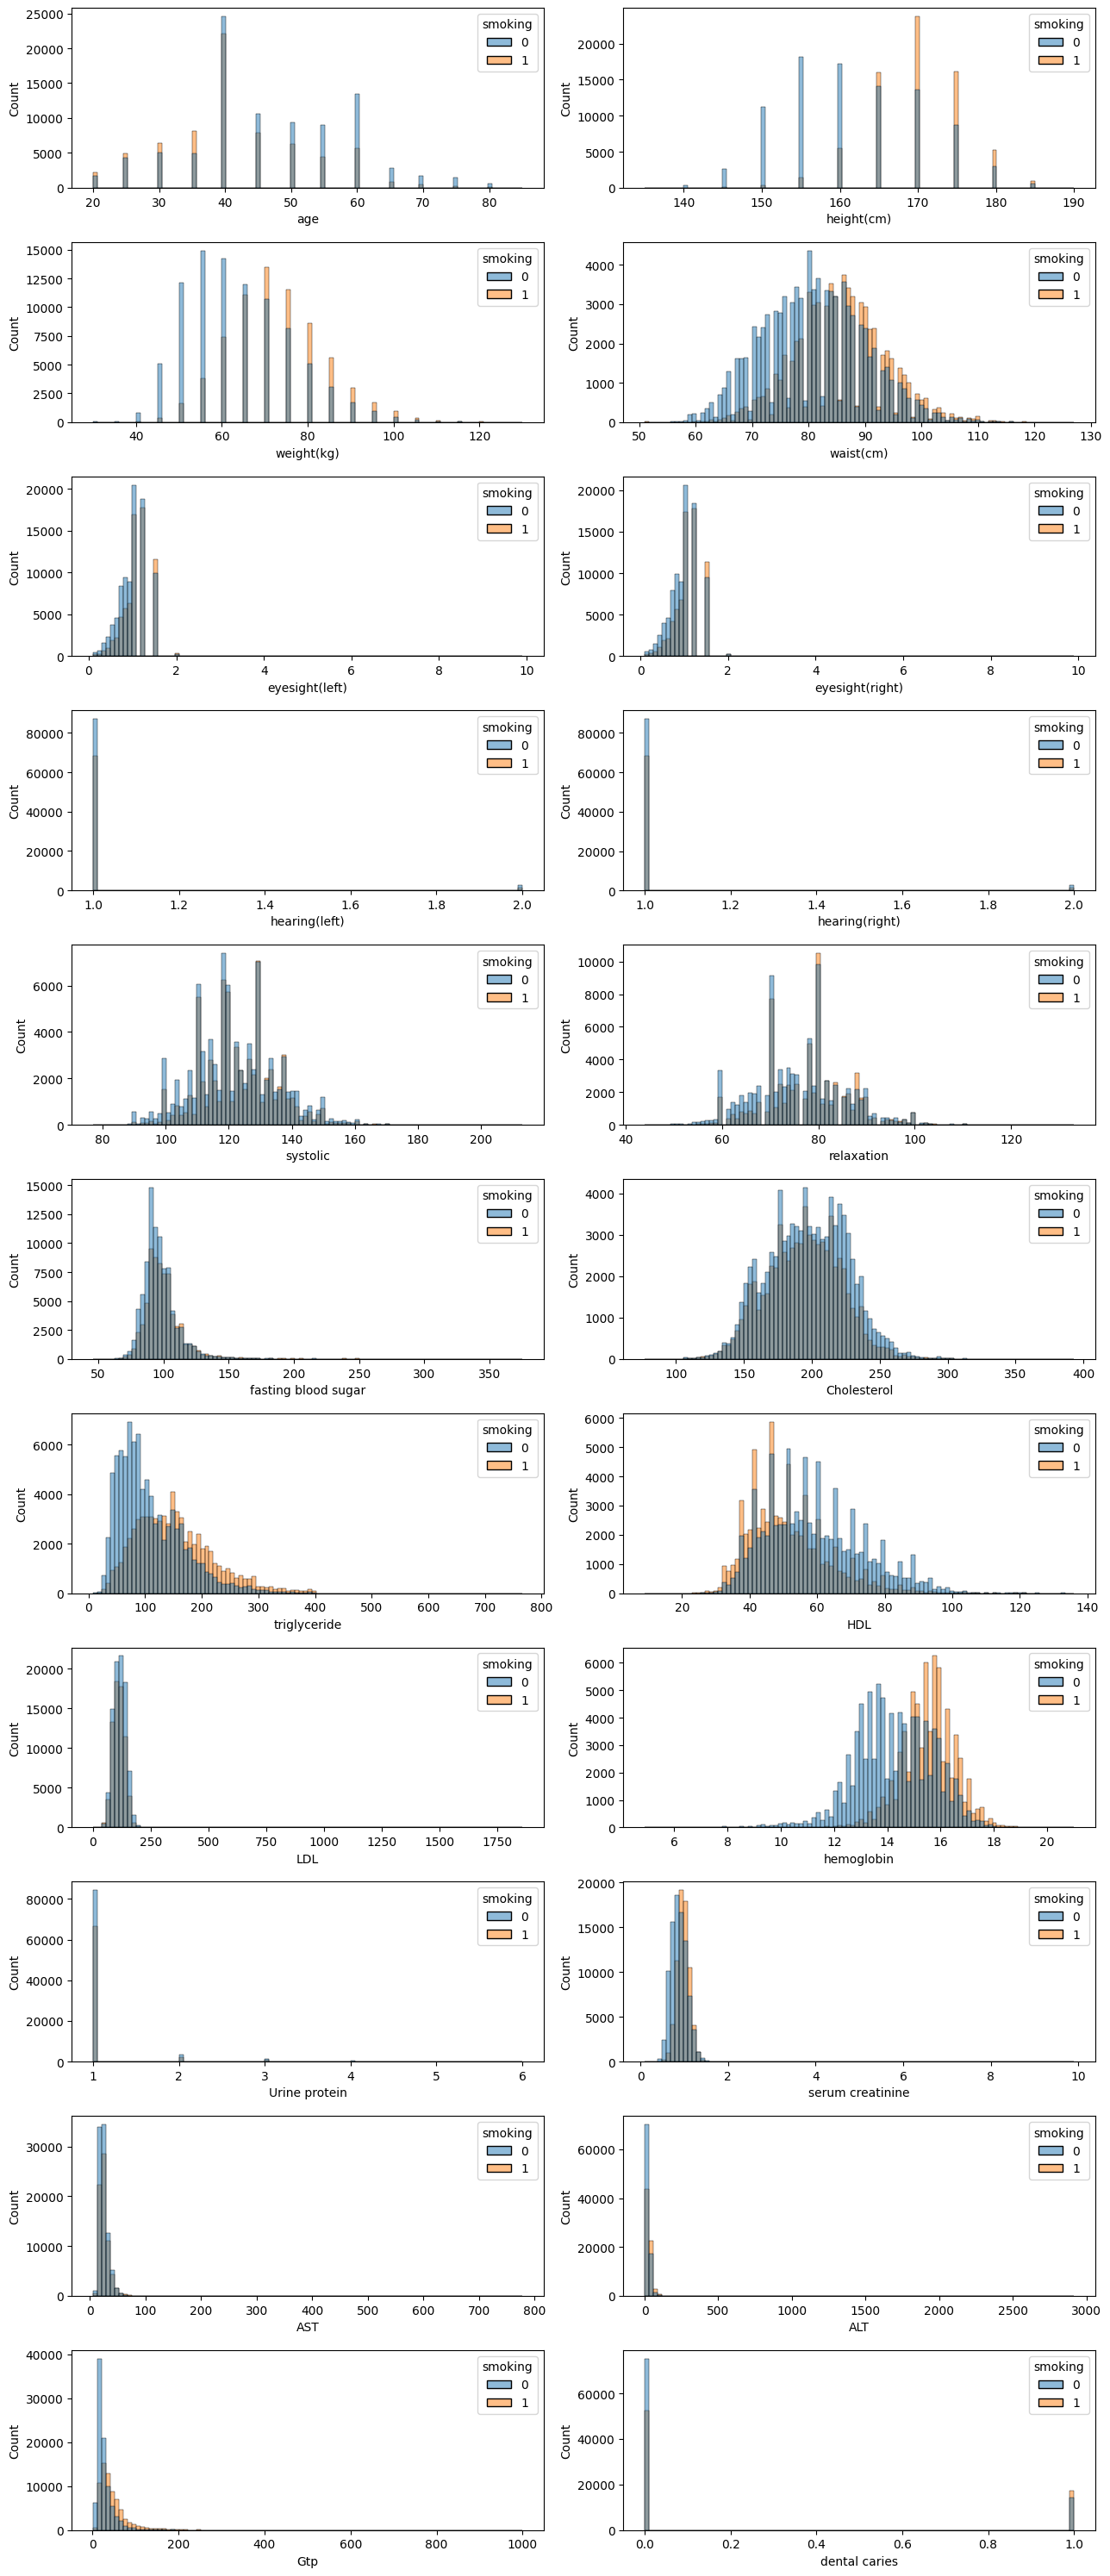

In [26]:
# For a closer look

fig =plt.figure(figsize=(13,30))

j=0
for i in test.columns:
    fig.add_subplot(11,2,j+1)
    sns.histplot(df,x=i,hue='smoking',fill=True,bins=100)
    j += 1
plt.tight_layout()
plt.show()

Points I observed in above graph:
most of the smokers have:
* 20 < age < 40
* height > 165
* 70 < weight < 100 
* 85 < waist < 105
* triglyceride > 150
* HDL < 50
* Hemoglobin > 50
* There are other observable factors but not so significant

most of the non smokers have:
* age >= 40
* height <=160
* weight <= 65
* waist <= 82
* triglyceride <= 110
* HDL >=55
* hemoglobin <= 14

In [27]:
def compare(feature_name, comparison = 'only_less',less_than = 0,greater_than = 0):
    #  smoking condition
    do = (df['smoking'] == 1)
    dont = (df['smoking'] == 0)
    
    if comparison == 'only_less':
        print()
        smokers = df[(df[feature_name] < less_than) & do].shape[0]
        non_smokers = df[(df[feature_name] < less_than) & dont].shape[0]
        print('{0:15} {1:5} {2:15} {3:15} {4:30}'.format(feature_name,smokers + non_smokers,smokers,non_smokers,smokers/non_smokers))
    
    elif comparison == 'only_greater':
        print()
        smokers = df[(df[feature_name] > greater_than) & do].shape[0]
        non_smokers = df[(df[feature_name] > greater_than) & dont].shape[0]
        print('{0:15} {1:5} {2:15} {3:15} {4:30}'.format(feature_name,smokers + non_smokers,smokers,non_smokers,smokers/non_smokers))
    
    else :
        print()
        smokers = df[(df[feature_name] < less_than) & (df[feature_name] > greater_than) & do].shape[0]
        non_smokers = df[(df[feature_name] < less_than) & (df[feature_name] > greater_than) & dont].shape[0]
        print('{0:15} {1:5} {2:15} {3:15} {4:30}'.format(feature_name,smokers + non_smokers,smokers,non_smokers,smokers/non_smokers))
    
        
print('{0:15} {1:15} {2:15} {3:15} {4:15}'.format('feature name','Total','smokers','Non-smokers','smoker to Non-smoker ratio'))
compare('age','both',40,20)
compare('height(cm)','only_greater',0,165)
compare('weight(kg)','both',100,70)
compare('waist(cm)','both',105,85)
compare('triglyceride','only_greater',0,150)
compare('HDL','only_less',50)
compare('hemoglobin','only_greater',0,15)

feature name    Total           smokers         Non-smokers     smoker to Non-smoker ratio

age             33686           19475           14211             1.3704172823868834

height(cm)      72042           46207           25835             1.7885426746661506

weight(kg)      49270           30361           18909             1.6056375271034957

waist(cm)       61998           34492           27506              1.253980949610994

triglyceride    51036           31807           19229             1.6541161786884393

HDL             60906           35152           25754             1.3649141880872875

hemoglobin      76896           48988           27908             1.7553389709044003


In [28]:
# Binning

def create_smoker_bins(df):
    age_filter = (df['age']>20)&(df['age']<40)
    height_filter = (df['height(cm)']>165)
    weight_filter = (df['weight(kg)']>70) & (df['weight(kg)']<100)
    waist_filter = (df['waist(cm)']>85) & (df['waist(cm)']<105)
    triglyceride_filter = (df['triglyceride']>150)
    hdl_filter = (df['HDL']<50)
    hemoglobin_filter = (df['hemoglobin']>15)
    
    
    df['age_bin'] = np.where(age_filter,1,0)
    df['height_bin'] = np.where(height_filter,1,0)
    df['weight_bin'] = np.where(weight_filter,1,0)
    df['waist_bin'] = np.where(waist_filter,1,0)
    df['triglyceride_bin'] = np.where(triglyceride_filter,1,0)
    df['hdl_bin'] = np.where(hdl_filter,1,0)
    df['hemoglobin_bin'] = np.where(hemoglobin_filter,1,0)
    df['all_smoker_bin'] = df['age_bin'] + df['height_bin'] + df['weight_bin'] + df['waist_bin'] + \
                        df['triglyceride_bin'] + df['hdl_bin'] + df['hemoglobin_bin']
    return df
df = create_smoker_bins(df)
df.sample(5)

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
154832   40         160          50     66.000           1.000   
23812    25         175          75     83.000           1.500   
48971    60         165          75     83.800           1.200   
110675   35         175          65     84.000           1.000   
23761    30         170          75     80.500           1.200   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
154832            1.000              1               1       110          70   
23812             1.500              1               1       132          85   
48971             1.000              1               1       134          86   
110675            1.200              1               1       118          78   
23761             1.200              1               1       118          78   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
154832                   98          157            87   59   80      13.500   
23812                    78          185           153   48  106      15.800   
48971                    96          160           164   38   89      15.400   
110675                  107          232           225   58  129      17.100   
23761                    82          188           208   47   99      16.500   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  \
154832              1             0.800   15    9   11              1   
23812               1             1.000   17   16   23              0   
48971               1             0.800   24   35   23              0   
110675              1             1.100   22   26   29              0   
23761               1             1.000   26   22   52              1   

        smoking  age_bin  height_bin  weight_bin  waist_bin  triglyceride_bin  \
154832        0        0           0           0          0                 0   
23812         1        1           1           1          0                 1   
48971         0        0           0           1          0                 1   
110675        1        1           1           0          0                 1   
23761         1        1           1           1          0                 1   

        hdl_bin  hemoglobin_bin  all_smoker_bin  
154832        0               0               0  
23812         1               1               6  
48971         1               1               4  
110675        0               1               4  
23761         1               1               6

In [29]:
# Blue Dominance
non_age_filter = (df['age']>= 40)
non_height_filter = (df['height(cm)'] <= 160)
non_weight_filter = (df['weight(kg)'] <= 65)
non_waist_filter = (df['waist(cm)'] <= 82)
non_triglyceride_filter = (df['triglyceride'] <= 110)
non_hdl_filter = (df['HDL'] >= 55)
non_hemoglobin_filter = (df['hemoglobin'] <= 14)

def show_blue_dominance(feature_name,feature_filter):
    do = (df['smoking'] == 1)
    dont = (df['smoking'] == 0)
    smokers = df[feature_name][feature_filter & do].shape[0]
    non_smokers = df[feature_name][feature_filter & dont].shape[0]
    print()
    print('{0:15} {1:5} {2:15} {3:15} {4:30} '.format(feature_name,smokers + non_smokers,smokers,non_smokers,non_smokers/smokers))
    
    
print('{0:15} {1:15} {2:15} {3:15} {4:15} '.format('feature_name','total','smokers','non_smokers','non_smoker to smoker ratio'))
show_blue_dominance('age',non_age_filter)
show_blue_dominance('height(cm)',non_height_filter)
show_blue_dominance('weight(kg)',non_weight_filter)
show_blue_dominance('waist(cm)',non_waist_filter)
show_blue_dominance('triglyceride',non_triglyceride_filter)
show_blue_dominance('HDL',non_hdl_filter)
show_blue_dominance('hemoglobin',non_hemoglobin_filter)

feature_name    total           smokers         non_smokers     non_smoker to smoker ratio 

age             121741           48001           73740             1.5362179954584279 

height(cm)      57069            7424           49645              6.687095905172414 

weight(kg)      83584           24278           59306             2.4427877090369883 

waist(cm)       75122           24139           50983             2.1120593230871205 

triglyceride    76252           21179           55073             2.6003588460267246 

HDL             74885           23538           51347             2.1814512702863453 

hemoglobin      46493            4712           41781              8.866935483870968 


In [30]:
# Binning

def create_non_bins(df):
    non_age_filter = (df['age']>= 40)
    non_height_filter = (df['height(cm)'] <= 160)
    non_weight_filter = (df['weight(kg)'] <= 65)
    non_waist_filter = (df['waist(cm)'] <= 82)
    non_triglyceride_filter = (df['triglyceride'] <= 110)
    non_hdl_filter = (df['HDL'] >= 55)
    non_hemoglobin_filter = (df['hemoglobin'] <= 14)
    
    df['non_age'] = np.where(non_age_filter,1,0)
    df['non_height'] = np.where(non_height_filter,1,0)
    df['non_weight'] = np.where(non_weight_filter,1,0)
    df['non_waist'] = np.where(non_waist_filter,1,0)
    df['non_triglyceride'] = np.where(non_triglyceride_filter,1,0)
    df['non_hdl'] = np.where(non_hdl_filter,1,0)
    df['non_hemoglobin'] = np.where(non_hemoglobin_filter,1,0)

    df['all_non_bin'] = df['non_age'] + df['non_height'] + df['non_weight'] + df['non_waist'] + df['non_triglyceride'] + \
                        df['non_hdl'] + df['non_hemoglobin']
    return df

df = create_non_bins(df)
df.sample(3)

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
9631     25         175          90     96.000           1.200   
12452    35         160          70     80.500           0.700   
149711   40         165          65     89.600           1.000   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
9631              1.200              1               1       138          77   
12452             0.800              1               1       110          80   
149711            0.800              1               1       117          81   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
9631                     94          187           151   49  109      14.300   
12452                    92          191           216   38  109      15.400   
149711                   97          207           125   55  128      15.200   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  \
9631                1             0.700   37   55   96              1   
12452               1             0.900   18   13   26              1   
149711              1             0.900   17   15   62              0   

        smoking  age_bin  height_bin  weight_bin  waist_bin  triglyceride_bin  \
9631          0        1           1           1          1                 1   
12452         1        1           0           0          0                 1   
149711        1        0           0           0          1                 0   

        hdl_bin  hemoglobin_bin  all_smoker_bin  non_age  non_height  \
9631          1               0               6        0           0   
12452         1               1               4        0           1   
149711        0               1               2        1           0   

        non_weight  non_waist  non_triglyceride  non_hdl  non_hemoglobin  \
9631             0          0                 0        0               0   
12452            0          1                 0        0               0   
149711           1          0                 0        1               0   

        all_non_bin  
9631              0  
12452             2  
149711            3

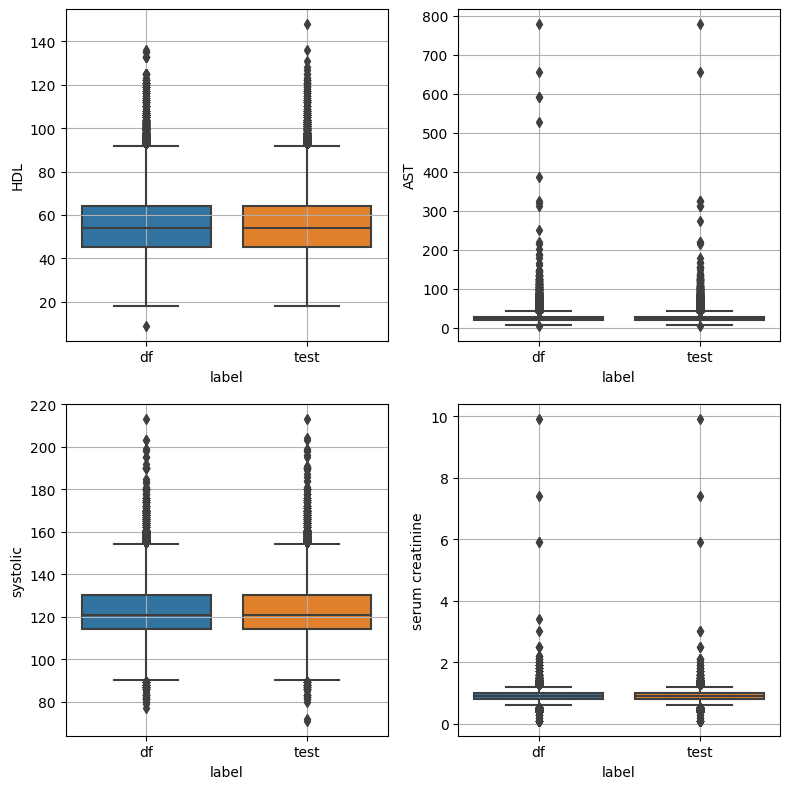

In [31]:
check1 = ['HDL','AST','systolic','serum creatinine']
fig = plt.figure(figsize=(8,8))
for i, col in enumerate(check1):
    df1 = pd.DataFrame(df[col].copy())
    df2 = pd.DataFrame(test[col].copy())
    
    df1['label']='df'
    df2['label']='test'
    
    combined_df = pd.concat([df1,df2])
    
    fig.add_subplot(2,2,i+1)
    sns.boxplot(combined_df,x='label',y=col)
    plt.grid()
plt.tight_layout()
plt.show()

In [32]:
# Removing Outlier
print(df[df['HDL']<18].shape[0])                  # only 1 sample
df.drop(df[df['HDL']<18].index[0],inplace=True)

1


### checking correlation

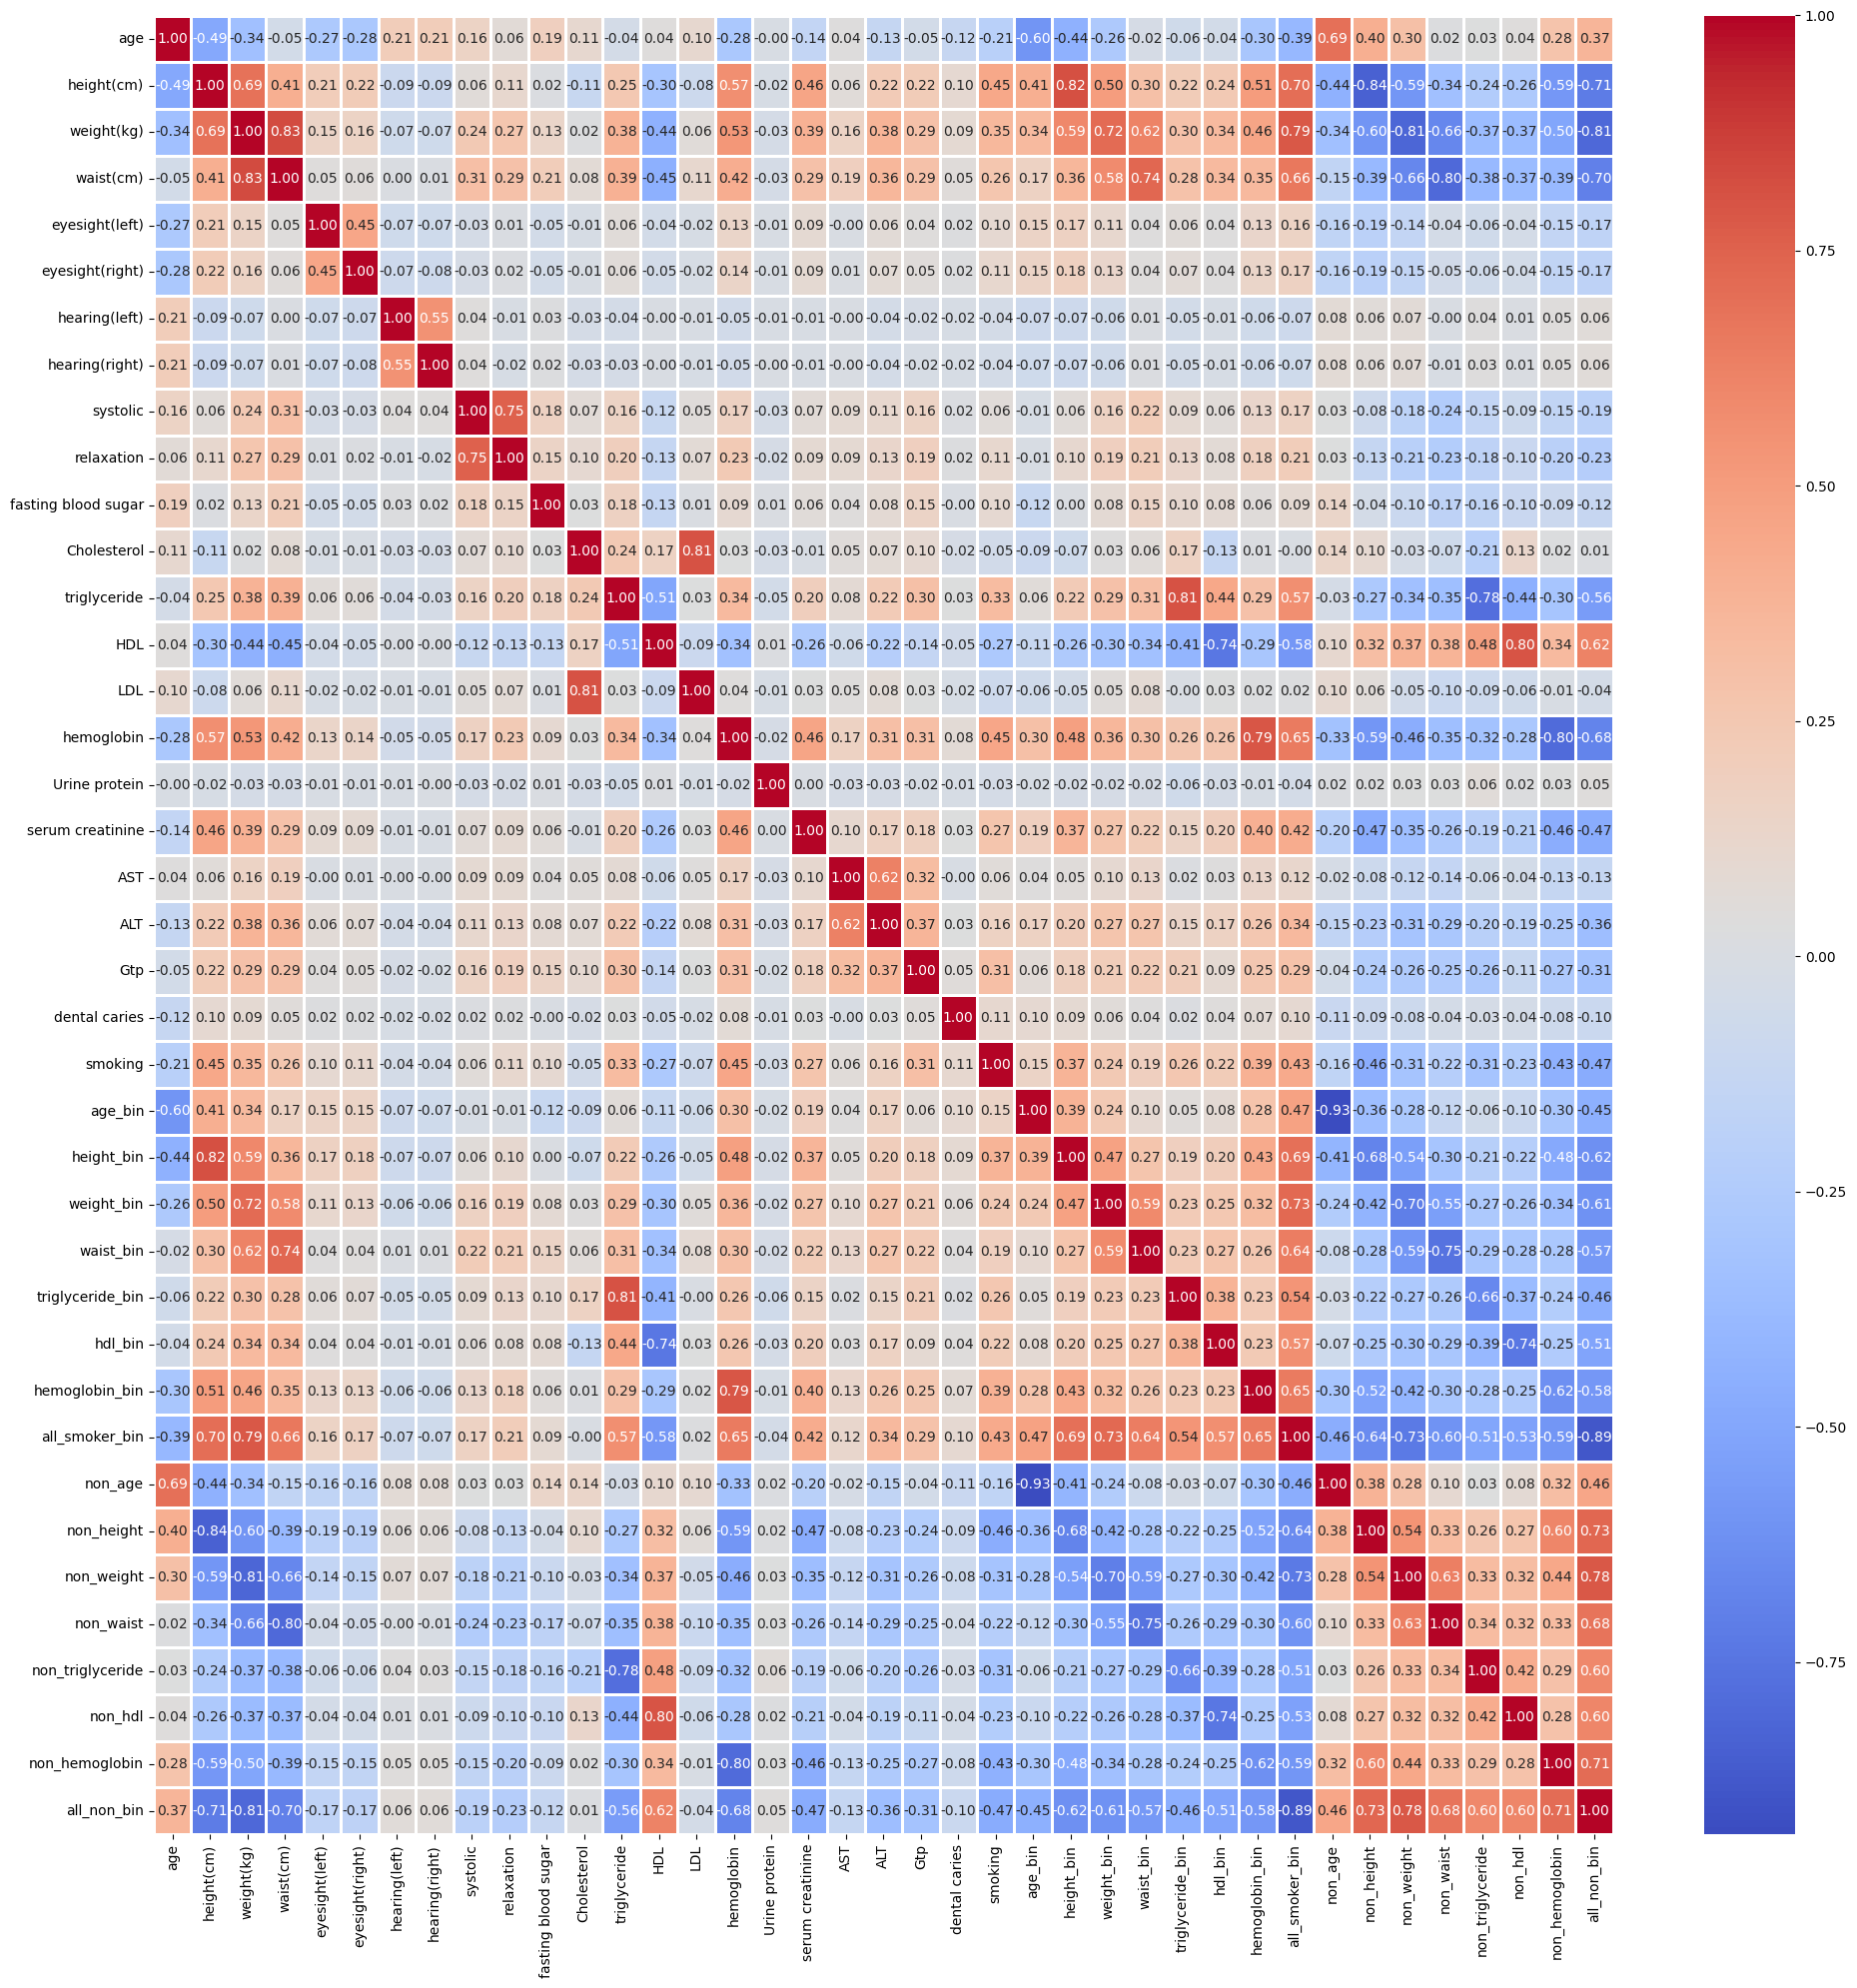

In [33]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap='coolwarm',linewidths=1)
plt.tight_layout()
plt.show()

Some important correlation appeared in original features as follows:
* weight to waist correlation is 0.83
* systolic to ralaxation correlation is 0.75
* cholesterol to LDL correlation is 0.81 

> Let's try multipy these to create new and better features

In [34]:
df['weight_waist'] = df['weight(kg)'] * df['waist(cm)']
df['systo_relax'] = df['systolic'] * df['relaxation']
df['chole_ldl'] = df['Cholesterol'] * df['LDL']

Now let's see mutual information of these features

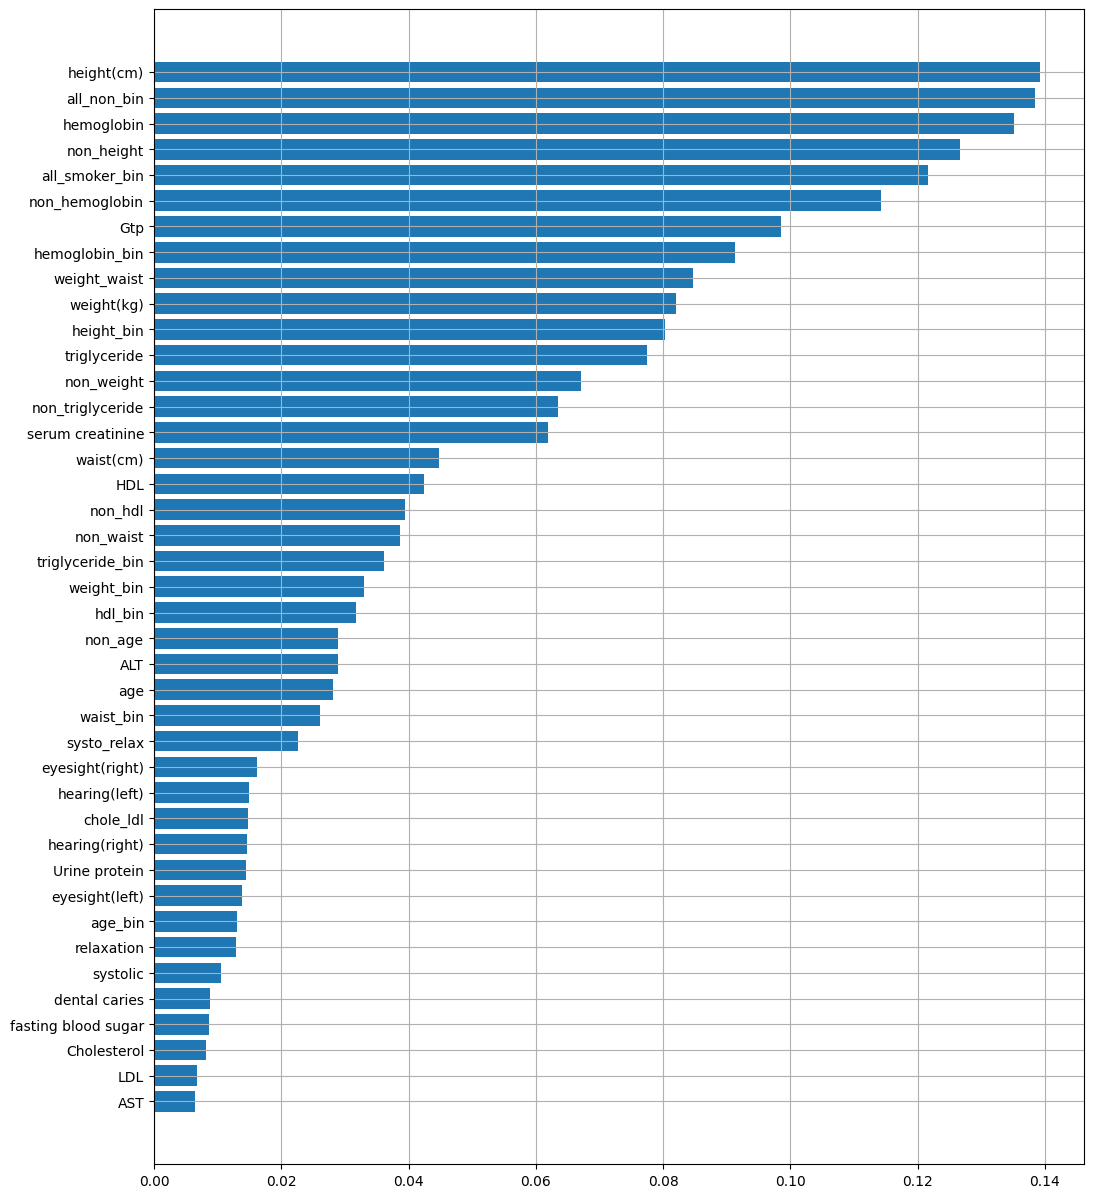

In [35]:
mut = mutual_info_classif(df.drop('smoking',axis=1),df['smoking'])
mut = pd.Series(mut,index=df.drop('smoking',axis=1).columns)
mut = mut.sort_values(ascending=True)

def plotting(s):
    plt.figure(figsize=(12,15),dpi=100)
    width = np.arange(len(s))
    ticks=s.index
    plt.barh(width,s)
    plt.yticks(width,ticks)
    plt.grid()
    
plotting(mut)

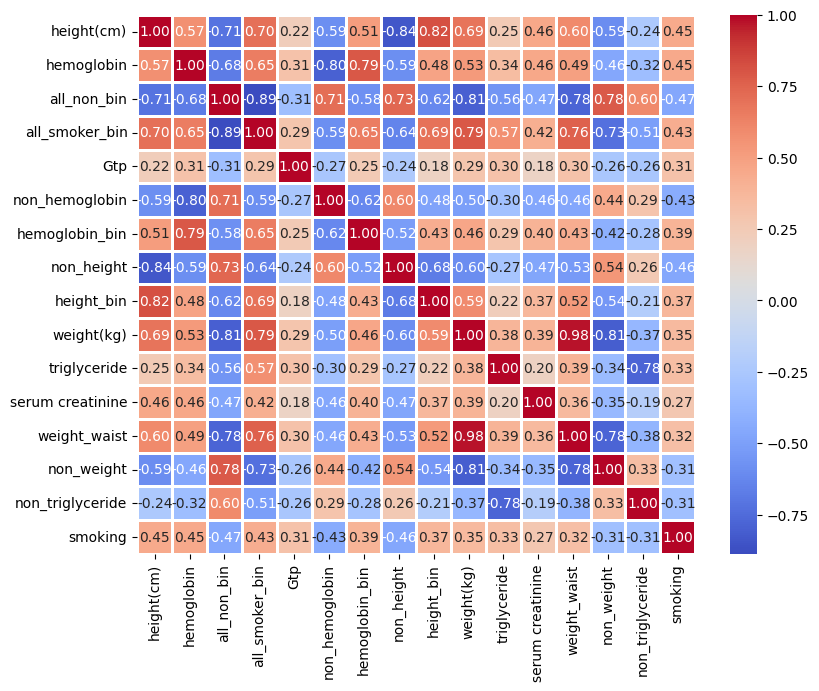

In [36]:
# Now we'll see correlation between features with MI score > 0.06 and target column
# This is a very important step in feature selection process
# I'll select those features with less mutual correlation but strong correlation with target feature

good_col = ['height(cm)','hemoglobin','all_non_bin','all_smoker_bin','Gtp','non_hemoglobin','hemoglobin_bin',
            'non_height','height_bin','weight(kg)','triglyceride','serum creatinine','weight_waist',
            'non_weight','non_triglyceride','smoking']

plt.figure(figsize=(9,7))
sns.heatmap(df[good_col].corr(),annot=True,fmt='.2f',cmap='coolwarm',linewidths=1)
plt.show()

Now we'll drop some features from this set based on there mutual correlation
* Dropping serum creatinine because of it's uneven distribution in train and test datasets

In [37]:
# MI score > 0.06
select1 = ['height(cm)','hemoglobin','all_non_bin','Gtp','hemoglobin_bin',
            'non_height','triglyceride','weight_waist',
            'non_weight','non_triglyceride']

# MI score > 0.08
select2 = ['height(cm)','hemoglobin','all_non_bin','Gtp','hemoglobin_bin',
            'non_height','weight_waist']

In [38]:
test = create_smoker_bins(test)
test = create_non_bins(test)

test['weight_waist'] = test['weight(kg)'] * test['waist(cm)']

# Model Building and Hyper Parameter Tuning

In [39]:
dff = df[select2 + ['smoking']].copy()
dff.shape, test[select2].shape

# it turns out that select1 is better

((159255, 8), (106171, 7))

## Cross Validation

In [40]:
x_temp = dff.drop('smoking',axis=1).copy()
y_temp = dff['smoking'].copy()
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)

out_cv = {}
out_proba_cv = {}

def cal_cv(model,label,stand = True, proba = True):
    auc_scores = []
    proba_auc_scores = []
    
    for train_idx,val_idx in skf.split(x_temp,y_temp):
        x_tr = x_temp.iloc[train_idx]
        y_tr = y_temp.iloc[train_idx]
        
        x_val = x_temp.iloc[val_idx]
        y_val = y_temp.iloc[val_idx]
        
        if stand == True:
            sc = StandardScaler()
            x_tr = sc.fit_transform(x_tr)
            x_val = sc.transform(x_val)
        
        model.fit(x_tr,y_tr)
        y_pred = model.predict(x_val)
        auc_scores.append(roc_auc_score(y_val,y_pred))
        
        if proba == True:
            y_proba = model.predict_proba(x_val)[:,1]
            proba_auc_scores.append(roc_auc_score(y_val,y_proba))
    
    final_auc = np.mean(auc_scores)
    
    if len(proba_auc_scores) != 0:
        final_proba_auc = np.mean(proba_auc_scores)
    else:
        final_proba_auc = 'NOT PREDICTED'
    
    out_cv[label]= final_auc
    out_proba_cv[label] = final_proba_auc
    
    return label, final_auc, final_proba_auc

Let's see score for Simple Linear Regression model

In [54]:
cal_cv(LinearRegression(),'Simple Linear Regression',proba=False)

('Simple Linear Regression', 0.8122251185005537, 'NOT PREDICTED')

In [42]:
clist = []
auclist = []

for C in np.logspace(3,4,9):
    label, auc, proba_auc = cal_cv(make_pipeline(PolynomialFeatures(2,include_bias=False),
                                                LogisticRegression(dual=False,
                                                                   C=C,
                                                                  class_weight='balanced',
                                                                  max_iter=1500,
                                                                  random_state=1,
                                                                  solver='newton-cholesky')),
                                  f'Poly Logistic Regression {C = }',
                                  stand=True,
                                  proba= True)
    print(label,auc,proba_auc)
    clist.append(C)
    auclist.append(proba_auc)

print(f'best C: {clist[auclist.index(max(auclist))]} and best AUC score: {max(auclist)}')

In [43]:
# After hours of Computation Finally reached maxima of C which is C=1333.521432 

#  {'Simple Linear Regression': 'NOT PREDICTED',
#   'Poly Logistic Regression C = 0.01': 0.8472420399675084,
#   'Poly Logistic Regression C = 0.023713737056616554': 0.8472766265079873,
#   'Poly Logistic Regression C = 0.05623413251903491': 0.8472900599918038,
#   'Poly Logistic Regression C = 0.1333521432163324': 0.8472947535016143,
#   'Poly Logistic Regression C = 0.31622776601683794': 0.8472963534220834,
#   'Poly Logistic Regression C = 0.7498942093324559': 0.847297083040709,
#   'Poly Logistic Regression C = 1.7782794100389228': 0.8472975437242101,
#   'Poly Logistic Regression C = 4.216965034285822': 0.847297703207006,
#   'Poly Logistic Regression C = 10.0': 0.8472977647075984,
#   'Poly Logistic Regression C = 100.0': 0.8472978918749228,
#   'Poly Logistic Regression C = 133.3521432163324': 0.8472978970863222,
#   'Poly Logistic Regression C = 177.82794100389228': 0.8472978939601484,
#   'Poly Logistic Regression C = 237.13737056616552': 0.8472978908335108,
#   'Poly Logistic Regression C = 316.22776601683796': 0.8472978960456479,
#   'Poly Logistic Regression C = 421.6965034285823': 0.8472978939609769,
#   'Poly Logistic Regression C = 562.341325190349': 0.8472978950033415,
#   'Poly Logistic Regression C = 749.8942093324558': 0.8472978960453666,
#   'Poly Logistic Regression C = 1000.0': 0.8472978981302198,
#   'Poly Logistic Regression C = 1333.521432163324': 0.8472979033415864,       <----------
#   'Poly Logistic Regression C = 1778.2794100389228': 0.847297902299189,
#   'Poly Logistic Regression C = 2371.373705661655': 0.8472979022990648,
#   'Poly Logistic Regression C = 3162.2776601683795': 0.8472979033413381,
#   'Poly Logistic Regression C = 4216.965034285822': 0.8472979022991561,
#   'Poly Logistic Regression C = 5623.413251903491': 0.8472979022992803,
#   'Poly Logistic Regression C = 7498.942093324558': 0.8472978991722119,
#   'Poly Logistic Regression C = 10000.0': 0.8472978991722119})

In [44]:
result_list = []
def cross_val(model, label):
    start_time = datetime.now()
    kf = StratifiedKFold(shuffle=True, random_state=1)
    oof = np.full(len(dff), np.nan)
    auc_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(x_temp, y_temp)):
        X_tr = x_temp.iloc[idx_tr]
        X_va = x_temp.iloc[idx_va]
        y_tr = y_temp.iloc[idx_tr]
        y_va = y_temp.iloc[idx_va]
        
        model.fit(X_tr, y_tr)
        try:
            y_va_pred = model.predict_proba(X_va)[:, 1]
        except AttributeError: # 'LinearSVC' object has no attribute 'predict_proba'
            y_va_pred = model.decision_function(X_va)
        oof[idx_va] = y_va_pred
        auc = roc_auc_score(y_va, y_va_pred)
        auc_list.append(auc)
    auc = np.array(auc_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# AUC {auc:.15f}   time={str(execution_time)[-15:-7]}   {label}")
#     result_list.append((auc, label, execution_time))
    return auc

In [45]:
min_samples_leaf_list = []
auclist = []

for min_samples_leaf in [10,20,30,40,50,70, 80,90,100,150,170,200]:
    start = datetime.now()
    label,auc,proba_auc = cal_cv(make_pipeline(RandomForestClassifier(n_estimators=100, 
                                                                    min_samples_leaf = min_samples_leaf,
                                                                    max_features=1.0,
                                                                    random_state=1)),
                                f'Random Forest with {min_samples_leaf = }',
                                stand=False,
                                proba=True)
    print(label,auc,proba_auc)
    print('Execution time:',datetime.now()-start)
    print() 
    min_samples_leaf_list.append(min_samples_leaf)
    auclist.append(proba_auc)

In [46]:
for min_samples_leaf in [1,2,3,5,7,8,9,10]:
    auc = cross_val(make_pipeline(
                                  ExtraTreesClassifier(n_estimators=100,
                                         min_samples_leaf=min_samples_leaf,
                                         max_features=1.0,
                                         random_state=1)),
                    f"ET {min_samples_leaf=}")
    
# At min_samples_leaf = 2 , AUC = 0.86644 

# with select 1
# AUC 0.811747948065179   time=0:03:13   ET min_samples_leaf=1
# AUC 0.823468916440913   time=0:03:08   ET min_samples_leaf=2

# with select 2
# AUC 0.776322407240131   time=0:02:37   ET min_samples_leaf=1
# AUC 0.805048407534366   time=0:02:20   ET min_samples_leaf=2

In [47]:
#* AUC 0.86079   time=0:04:50   ET min_samples_leaf=10
#* AUC 0.85709   time=0:04:11   ET min_samples_leaf=20
#* AUC 0.85243   time=0:03:39   ET min_samples_leaf=50
#* AUC 0.84863   time=0:03:28   ET min_samples_leaf=100
#* AUC 0.84618   time=0:03:49   ET min_samples_leaf=150
#* AUC 0.86552   time=0:07:09   ET min_samples_leaf=1
#* AUC 0.86644   time=0:06:07   ET min_samples_leaf=2
#* AUC 0.86615   time=0:05:56   ET min_samples_leaf=3
#* AUC 0.86449   time=0:05:18   ET min_samples_leaf=5
#* AUC 0.86287   time=0:05:18   ET min_samples_leaf=7
#* AUC 0.86210   time=0:05:28   ET min_samples_leaf=8
#* AUC 0.86169   time=0:05:22   ET min_samples_leaf=9
#* AUC 0.86079   time=0:05:30   ET min_samples_leaf=10

In [48]:
for n_neighbors in range(72, 77, 1):
    auc = cross_val(make_pipeline(KNeighborsClassifier(n_neighbors=n_neighbors,
                                                       weights='distance')),
                    f"KNN {n_neighbors=}")
# AUC 0.837221   time=0:01:14   KNN n_neighbors=73

In [49]:
# HistGradientBoostingClassifier
auc = cross_val(HistGradientBoostingClassifier(random_state=1),
                f"HistGradientBoostingClassifier")
# AUC 0.861615591771725   time=0:00:11   HistGradientBoostingClassifier

In [50]:
ensemble = VotingClassifier([('HistGrad',HistGradientBoostingClassifier(random_state=1)),
                            ('RandForest',RandomForestClassifier(n_estimators=100,
                                                                min_samples_leaf = 2,
                                                                max_features=1.0,
                                                                random_state=1)),
                            ('ExtraTree',ExtraTreesClassifier(n_estimators=100,
                                                             min_samples_leaf =2,
                                                             max_features=1.0,
                                                             random_state=1))],
                            voting='soft',
                            weights=[0.2,0.4,0.4])

auc = cross_val(ensemble,'HG + RF + ET')

In [51]:
cross_val(XGBClassifier(),'Simple XGB')
cross_val(CatBoostClassifier(),'Simple CatBoost')
cross_val(GradientBoostingClassifier(),'Simple GB')
cross_val(LGBMClassifier(),'Simple LGBM')

Simple XGB               0.864513
Simple CatBoost          0.867679    
Simple GB                0.854838
Simple LGBM              0.861811

In [52]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',500,1000),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
        "subsample" : trial.suggest_float('subsample', 0.2, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
    }
    lgbmmodel_optuna = LGBMClassifier(**params,random_state=1,device="gpu")
    cv = cross_val_score(lgbmmodel_optuna, x_temp, y_temp, cv = 4,scoring='roc_auc').mean()
    return cv

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,timeout=2000)
print(study.best_value) 

In [ ]:
print(study.best_params)
print()
print(study.best_value)

In [ ]:
best_param_yet = {'n_estimators': 919, 
                  'max_depth': 19, 
                  'learning_rate': 0.0487737902973404, 
                  'min_child_weight': 1.558466463989505, 
                  'min_child_samples': 216, 
                  'subsample': 0.9462573827656944, 
                  'subsample_freq': 5, 
                  'colsample_bytree': 0.6329418580323135, 
                  'num_leaves': 57}

# For without ori
# study.best_value: 0.8710607398384727
new_param = {'n_estimators': 746, 'max_depth': 29, 
             'learning_rate': 0.02889687137159223, 
             'min_child_weight': 2.9072642727142783, 
             'min_child_samples': 172, 
             'subsample': 0.37716436254808705, 
             'subsample_freq': 0, 
             'colsample_bytree': 0.2858048478215879, 
             'num_leaves': 122}

label_cal,_,proba_auc,lgbm_df_one = cal_cv(LGBMClassifier(**new_param,device='gpu'), 'LGBM grid3',stand=False)
print(label_cal, proba_auc) 
# LGBM grid2 0.8662444218345303

auc,lgbm_df_two = cross_val(LGBMClassifier(**new_param,device_type='gpu'),'LGBM grid3')

# LGBM grid3 0.8695926989129232
# # AUC 0.865065367700705   time=0:01:44   LGBM grid3

# without ori
# LGBM grid3 0.8717801385434415
# # AUC 0.871034752354943   time=0:01:29   LGBM grid3

# without ori and with new_param
# LGBM grid3 0.8721356728366804
# # AUC 0.871460319886812   time=0:01:24   LGBM grid3

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',500,750),
        'max_depth':  trial.suggest_int('max_depth',3,50),
        'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2,log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
        "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }
    xgbmodel_optuna = XGBClassifier(**params,random_state=1,tree_method = "gpu_hist",eval_metric= "auc")   # verbose=500  not used
    cv = cross_val_score(xgbmodel_optuna, x_temp, y_temp, cv = 4,scoring='roc_auc').mean()
    return cv

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100,timeout=5000)

# Best is trial 91 with value: 0.8691347612295083.

In [ ]:
print('Best params: ',study_xgb.best_params)
print()
print('Best Value: ',study_xgb.best_value)

# {'n_estimators': 675, 
#  'max_depth': 11, 
#  'min_child_weight': 40.86869889025276, 
#  'learning_rate': 0.05576041911952706, 
#  'subsample': 0.9203427230250661, 
#  'gamma': 0.1280337855575941, 
#  'colsample_bytree': 0.8088703971777005, 
#  'colsample_bylevel': 0.6225557766971302, 
#  'colsample_bynode': 0.5064749820987031}

# Best Value:  0.8691347612295083

In [ ]:

xgb_optuna_param = {'n_estimators': 675, 
     'max_depth': 11, 
     'min_child_weight': 40.86869889025276, 
     'learning_rate': 0.05576041911952706, 
     'subsample': 0.9203427230250661, 
     'gamma': 0.1280337855575941, 
     'colsample_bytree': 0.8088703971777005, 
     'colsample_bylevel': 0.6225557766971302, 
     'colsample_bynode': 0.5064749820987031}

label_cal,_,proba_auc = cal_cv(XGBClassifier(**xgb_optuna_param,tree_method='gpu_hist',eval_metric='auc',random_state=1), 
                               'XGB Optuna Trial 1',stand=False)
print(label_cal, proba_auc)

auc = cross_val(XGBClassifier(**xgb_optuna_param,tree_method='gpu_hist',eval_metric="auc",random_state=1),'XGB Optuna Trial 1')
# XGB Optuna Trial 1 0.8695700080964549
# AUC 0.868799996766472   time=0:00:32   XGB Optuna Trial 1

## Out of Fold CROSS VALIDATION

In [ ]:
SPLITS = 5
REPEATS = 3
lgb_scores = []
xgb_scores = []
cat_scores = []
denominator=0

for i, (tr_idx,val_idx) in enumerate(RepeatedStratifiedKFold(n_splits=SPLITS, n_repeats=REPEATS, random_state=1).split(x_temp,y_temp)):
    x_tr,y_tr,x_val,y_val = x_temp.iloc[tr_idx],y_temp.iloc[tr_idx],x_temp.iloc[val_idx],y_temp.iloc[val_idx]
    start = datetime.now()
    print('-'*40,f'Fold {i+1}/{SPLITS*REPEATS} ','-'*40)
    print('LGBM -->')
    print()
    
    lgbm = LGBMClassifier(**best_param_yet,random_state=1,device='gpu')
    lgbm.fit(x_tr,y_tr, eval_set=[(x_val,y_val)], eval_metric='auc', early_stopping_rounds=500, verbose=500)
    auc = roc_auc_score(y_val,lgbm.predict_proba(x_val)[:,1])
    lgb_scores.append(auc)
    denominator += 1
    sub['smoking'] = sub['smoking'] + lgbm.predict_proba(test)[:,1]
    print('-'*40,f'Fold {i+1} LGBM ROC score: {auc}    ','-'*40)
    
    print()
    print('CAT -->')
    print()
    
    cat = CatBoostClassifier(iterations=7500, verbose=500, od_type= 'Iter', eval_metric= 'AUC', random_state=1, 
                             early_stopping_rounds = 500)
    # eval_metric = 'auc' gives error in catboost
    cat.fit(x_tr,y_tr, eval_set=[(x_val,y_val)], use_best_model=True)
    auc = roc_auc_score(y_val,cat.predict_proba(x_val)[:,1])
    cat_scores.append(auc)
    denominator += 1
    sub['smoking'] = sub['smoking'] + cat.predict_proba(test)[:,1]
    print('-'*40,f'Fold {i+1} CATBOOST ROC score: {auc}   ','-'*40)
    
    print()
    print('XGB -->')
    print()
    
    xgb = XGBClassifier(**xgb_optuna_param, random_state=1, tree_method= 'gpu_hist', eval_metric='auc', early_stopping_rounds= 500)
    xgb.fit(x_tr,y_tr, eval_set=[(x_val,y_val)], verbose=500, callbacks =[EarlyStopping(rounds=500, save_best=True)])
    auc = roc_auc_score(y_val,xgb.predict_proba(x_val)[:,1])
    xgb_scores.append(auc)
    denominator += 1
    sub['smoking'] += xgb.predict_proba(test)[:,1]
    print('-'*40,f'Fold {i+1} XGBOOST ROC score: {auc  } ','-'*40)
    
    print()
    print('='*30,f'Execution time of Fold{i+1}: {datetime.now() - start}  ','='*30)
    
print('\n\n','='*60)
print(f'CV score of LGBM is {np.array(lgb_scores).mean()}')
print(f'CV score of CatBoost is {np.array(cat_scores).mean()}')
print(f'CV score of XGB is {np.array(xgb_scores).mean()}')

In [ ]:
sub['smoking'] = sub['smoking']/denominator
sub.to_csv('final_submission.csv',index=False)
sub.head(10)